https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"

pd.set_option("display.max_columns", 2000)

import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
with timer('read application_train.csv'):
    app_train = pd.read_csv(path + "application_train.csv")

read application_train.csv - done in 3s


In [3]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [4]:
with timer('read bureau.csv'):
    bureau = pd.read_csv(path + "bureau.csv")

read bureau.csv - done in 2s


In [5]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [6]:
with timer('read bureau_balance.csv'):
    bureau_balance = pd.read_csv(path + "bureau_balance.csv")

read bureau_balance.csv - done in 5s


In [7]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [8]:
with timer('read credit_card_balance.csv'):
    credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")

read credit_card_balance.csv - done in 8s


In [9]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [10]:
with timer('read POS_CASH_balance.csv'):
    pcb = pd.read_csv(path + "POS_CASH_balance.csv")

read POS_CASH_balance.csv - done in 6s


In [11]:
pcb.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [12]:
with timer('read previous_application.csv'):
    previous_application = pd.read_csv(path + "previous_application.csv")

read previous_application.csv - done in 6s


In [13]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [14]:
with timer('read installments_payments.csv'):
    installments_payments = pd.read_csv(path + "installments_payments.csv")

read installments_payments.csv - done in 11s


In [15]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

## 学習データ準備

In [16]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb


with timer('read application_test.csv'):
    app_test = pd.read_csv('../input/application_test.csv')


with timer('perapare'):
    app_test['is_test'] = 1 
    app_test['is_train'] = 0
    app_train['is_test'] = 0
    app_train['is_train'] = 1

    # target variable
    Y = app_train['TARGET']
    train_X = app_train.drop(['TARGET'], axis = 1)

    # test ID
    test_id = app_test['SK_ID_CURR']
    test_X = app_test

    # merge train and test datasets for preprocessing
    data = pd.concat([train_X, test_X], axis=0)

read application_test.csv - done in 1s
perapare - done in 1s


### <a id="0.1">0.1 Prepare - Data Cleaning</a>

In [17]:

with timer('app remove meaningless feature'):
    data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)

with timer('replace outliers'):
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    data['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    data['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    data['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
    data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    data.loc[data['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    data.loc[data['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    data.loc[data['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    data.loc[data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    data.loc[data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan


app remove meaningless feature - done in 0s
replace outliers - done in 0s


In [18]:
with timer('bureau replace outliers'):
    bureau['AMT_CREDIT_SUM'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0, inplace=True)
    bureau['CNT_CREDIT_PROLONG'].fillna(0, inplace=True)

    bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
    bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
    bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] < -40000] = np.nan

bureau replace outliers - done in 0s


In [19]:
with timer('previous_application replace outliers'):
    previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
      

previous_application replace outliers - done in 0s


In [20]:
with timer('credit_card_balance replace outliers'):
    credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'][credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
    credit_card_balance['AMT_DRAWINGS_CURRENT'][credit_card_balance['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

credit_card_balance replace outliers - done in 0s


## feature engineering

In [21]:
with timer('app features1'):
    
    data['app NAN num'] = data.isnull().sum(axis = 1).values        

    data['app CNT_FAM_MEMBERS - CNT_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']        
    
    data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app AMT_CREDIT / AMT_ANNUITY / DAYS_EMPLOYED'] = data['app AMT_CREDIT / AMT_ANNUITY'] / data['DAYS_EMPLOYED']
    data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app AMT_CREDIT - AMT_GOODS_PRICE'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / AMT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / CNT_FAM_MEMBERS'] = data['AMT_CREDIT'] / data['CNT_FAM_MEMBERS']
    data['app AMT_CREDIT / (1 + CNT_CHILDREN)'] = data['AMT_CREDIT'] / (1 + data['CNT_CHILDREN'])
    data['app AMT_CREDIT / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['AMT_CREDIT'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']   
    
    data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app AMT_ANNUITY / AMT_CREDIT'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    
    data['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / 12. - data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = data['AMT_INCOME_TOTAL'] - data['AMT_GOODS_PRICE']
    data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])       
    data['app AMT_INCOME_TOTAL / AMT_CREDIT'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['app AMT_INCOME_TOTAL / (CNT_FAM_MEMBERS - CNT_CHILDREN) '] = data['AMT_INCOME_TOTAL'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    
    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    data['app EXT_SOURCE mean'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    data['app EXT_SOURCE std'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    data['app EXT_SOURCE prod'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = data['EXT_SOURCE_1'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = data['EXT_SOURCE_2'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = data['EXT_SOURCE_3'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_1 / DAYS_BIRTH'] = data['EXT_SOURCE_1'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_2 / DAYS_BIRTH'] = data['EXT_SOURCE_2'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_3 / DAYS_BIRTH'] = data['EXT_SOURCE_3'] / data['DAYS_BIRTH']

    data['app OWN_CAR_AGE / DAYS_BIRTH'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['app OWN_CAR_AGE / DAYS_EMPLOYED'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']

    data['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
    data['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']

    data['app DAYS_EMPLOYED - DAYS_BIRTH'] = data['DAYS_EMPLOYED'] - data['DAYS_BIRTH']
    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['app DAYS_EMPLOYED - DAYS_REGISTRATION'] = data['DAYS_EMPLOYED'] - data['DAYS_REGISTRATION']
    data['app DAYS_EMPLOYED - DAYS_ID_PUBLISH'] = data['DAYS_EMPLOYED'] - data['DAYS_ID_PUBLISH']
    
    data['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
    data['app CNT_CHILDREN / CNT_CHILDREN'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
    data['app CNT_CHILDREN / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['CNT_CHILDREN'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    
    data['app OBS_30_CNT_SOCIAL_CIRCLE - DEF_30_CNT_SOCIAL_CIRCLE'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] - data['DEF_30_CNT_SOCIAL_CIRCLE']
    data['app OBS_60_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] - data['DEF_60_CNT_SOCIAL_CIRCLE']
    
with timer('app features2'):
    data['app most popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    data['app popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    data['app TOTAL_DOCS_SUBMITTED'] = data.loc[:, data.columns.str.contains('FLAG_DOCUMENT')].sum(axis=1)
    data['app DAYS_EMPLOYED < -2000'] = (data['DAYS_EMPLOYED'] < -2000).astype(int)
    data['DAYS_BIRTH < -14000'] = (data['DAYS_BIRTH'] < -14000).astype(int)


app features1 - done in 1s
app features2 - done in 0s


In [22]:
with timer('app features handcraft definition'):
    data['app self cate OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace(
                       {'High skill tech staff':0,
                        'Managers':0,
                        'Accountants':0,
                        'HR staff':0,
                        'Core staff':0,
                       'Cooking staff':1,
                        'Realty agents':0,
                        'Sales staff':1,
                        'IT staff':0,
                        'Medicine staff':0,
                        'Secretaries':0,
                        'Security staff':1,
                        'Cleaning staff':1,
                          'Laborers':1,
                          'Low-skill Laborers':1,
                          'Cleaning staff':1,
                        'Waiters/barmen staff':1,
                        'Private service staff':0,
                        'Drivers':1,
                        'High skill tech staff':0                                                                       
                        },inplace=False)

    data['app self cate NAME_INCOME_TYPE'] = data['NAME_INCOME_TYPE'].replace(
                        {'Businessman':0,
                         'Student':0,
                         'Unemployed':1,
                         'Working':1,
                         'Commercial associate':0,                        
                         'State servant':0,
                         'Pensioner':0,                         
                         'Maternity leave':1}
                        ,inplace=False)

    data['app self cate NAME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].replace(
                        {'Rented apartment':1,
                         'With parents':1,
                         'Municipal apartment':0,
                         'Co-op apartment':0,
                         'House / apartment':0,                        
                         'Office apartment':0}
                        ,inplace=False)

    data['app self cate ORGANIZATION_TYPE'] = data['ORGANIZATION_TYPE'].replace(
                        {'Transport':1, 
                        'Industry: type 13':1, 
                        'Industry: type 8':1, 
                        'Transport: type 3':1,
                        'Restaurant':1, 
                        'Construction':1,
                        'Cleaning':1,
                        'Industry: type 1':1,
                        'Industry: type 3':1,
                        'Realtor':1,
                        'Agriculture':1,
                        'Trade: type 3':1,
                        'Self-employed':1,
                        'Industry: type 4':1,
                        'Security':0,
                        'Trade: type 7':0,
                        'Business Entity Type 3':0,
                        'Transport: type 4':0,
                        'Mobile':0,
                        'Trade: type 1':0,
                        'Industry: type 11':0,
                        'Business Entity Type 2':0,
                        'Postal':0,
                        'Advertising':0,
                        'Business Entity Type 1':0,
                        'Industry: type 7':0,
                        'Housing':0,
                        'Legal Services':0,
                        'Transport: type 2':0,
                        'Other':0,
                        'Telecom':0,
                        'Industry: type 2':0,
                        'Industry: type 6':0,
                        'Emergency':0,
                        'Kindergarten':0,
                        'Trade: type 2':0,
                        'Government':0,
                        'Industry: type 5':0,
                        'Industry: type 9':0,
                        'Electricity':0,
                        'Services':0,
                        'Medicine':0,
                        'Industry: type 10':0,
                        'Hotel':0,
                        'Trade: type 5':0,
                        'School':0,
                        'Religion':0,
                        'Insurance':0,
                        'Culture':0,
                        'XNA':0,
                        'Bank':0,
                        'Military':0,
                        'Police':0,
                        'University':0,
                        'Security Ministries':0,
                        'Trade: type 6':0,
                        'Transport: type 1':0,
                        'Industry: type 12':0,
                        'Trade: type 4':0}
                        ,inplace=False)        

app features handcraft definition - done in 1s


In [23]:
with timer('app features handcraft'):
    ### 勝手にデータ定義して作ってみたものの、事実に基づいてないからダメかもしれない。あんまり足すのはやめておこう。
    # app self cate OCCUPATION_TYPE
    data['app self cate occ AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_CREDIT / AMT_ANNUITY'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate occ DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate OCCUPATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_INCOME_TYPE
    data['app self cate income AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate income DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_INCOME_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_HOUSING_TYPE
    data['app self cate housing AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate housing DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_HOUSING_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate ORGANIZATION_TYPE
    data['app self cate org AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_CREDIT / AMT_ANNUITY'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate org DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate ORGANIZATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    

app features handcraft - done in 0s


In [24]:
data.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working  Secondary / secondary special   
1          Family    State servant               Higher education   
2   Unaccompanied          Working  Secondary / secondary special   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0  Single / not married  House / apartment                    0.018801   
1               Married  House / apartment                    0.003541   
2  Single / not married  House / apartment                    0.010032   
3        Civil marriage  House / apartment                    0.008019   
4  Single / not married  House / apartment                    0.028663   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0       -9461         -637.0            -3648.0            -2120          NaN   
1      -16765        -1188.0            -1186.0             -291          NaN   
2      -19046         -225.0            -4260.0            -2531         26.0   
3      -19005        -3039.0            -9833.0            -2437          NaN   
4      -19932        -3038.0            -4311.0            -3458          NaN   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           1   
1           1               1                0                 1           1   
2           1               1                1                 1           1   
3           1               1                0                 1           0   
4           1               1                0                 1           0   

   FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0        Laborers              1.0                     2   
1           0      Core staff              2.0                     1   
2           0        Laborers              1.0                     2   
3           0        Laborers              2.0                     2   
4           0      Core staff              1.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                          2.0                  WEDNESDAY   
1                          1.0                     MONDAY   
2                          2.0                     MONDAY   
3                          2.0                  WEDNESDAY   
4                          2.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         

In [25]:
with timer('app groupby features define'):
    APP_AGGREGATION_RECIPIES = [
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                                  ('AMT_CREDIT', 'max'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('OWN_CAR_AGE', 'max'),
                                                  ('OWN_CAR_AGE', 'sum')]),
        (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                                ('AMT_INCOME_TOTAL', 'mean'),
                                                ('DAYS_REGISTRATION', 'mean'),
                                                ('EXT_SOURCE_1', 'mean')]),
        (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                     ('CNT_CHILDREN', 'mean'),
                                                     ('DAYS_ID_PUBLISH', 'mean')]),
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                               ('EXT_SOURCE_2', 'mean')]),
        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                      ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                      ('APARTMENTS_AVG', 'mean'),
                                                      ('BASEMENTAREA_AVG', 'mean'),
                                                      ('EXT_SOURCE_1', 'mean'),
                                                      ('EXT_SOURCE_2', 'mean'),
                                                      ('EXT_SOURCE_3', 'mean'),
                                                      ('NONLIVINGAREA_AVG', 'mean'),
                                                      ('OWN_CAR_AGE', 'mean'),
                                                      ('YEARS_BUILD_AVG', 'mean')]),
        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                                ('EXT_SOURCE_1', 'mean')]),
        (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                               ('CNT_CHILDREN', 'mean'),
                               ('CNT_FAM_MEMBERS', 'mean'),
                               ('DAYS_BIRTH', 'mean'),
                               ('DAYS_EMPLOYED', 'mean'),
                               ('DAYS_ID_PUBLISH', 'mean'),
                               ('DAYS_REGISTRATION', 'mean'),
                               ('EXT_SOURCE_1', 'mean'),
                               ('EXT_SOURCE_2', 'mean'),
                               ('EXT_SOURCE_3', 'mean')]),
        (['NAME_CONTRACT_TYPE'], [('app AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                  ('app EXT_SOURCE mean', 'max'),
                                  ('app DAYS_EMPLOYED / DAYS_BIRTH', 'mean')]),
        (['REGION_RATING_CLIENT', 'NAME_HOUSING_TYPE'], [('AMT_CREDIT', 'mean'),
                                                      ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                      ('APARTMENTS_AVG', 'mean'),
                                                      ('BASEMENTAREA_AVG', 'mean'),
                                                      ('EXT_SOURCE_1', 'mean'),
                                                      ('EXT_SOURCE_2', 'mean'),
                                                      ('EXT_SOURCE_3', 'mean'),
                                                      ('NONLIVINGAREA_AVG', 'mean'),
                                                      ('OWN_CAR_AGE', 'mean'),
                                                      ('YEARS_BUILD_AVG', 'mean')]),
        (['CODE_GENDER', 'NAME_INCOME_TYPE'], [('AMT_ANNUITY', 'mean'),
                                                ('app AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                                ('DAYS_REGISTRATION', 'mean'),
                                                ('OWN_CAR_AGE', 'mean'),                                               
                                                ('EXT_SOURCE_1', 'mean')]), 
    ]

app groupby features define - done in 0s


In [26]:
def make_agg_by_recipies(targetData, RECIPES, prefix):
    groupby_aggregate_names = []
    for groupby_cols, specs in tqdm(RECIPES):
        group_object = targetData.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = '{}_{}_{}_{}'.format(prefix, '_'.join(groupby_cols), agg, select)
            targetData = targetData.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
            groupby_aggregate_names.append(groupby_aggregate_name)
    return targetData

In [27]:
def make_agg_diff_by_recipies(targetData, RECIPES, prefix):
    groupby_aggregate_names = []
    for groupby_cols, specs in tqdm(RECIPES):
        group_object = targetData.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = '{}_{}_{}_{}'.format(prefix, '_'.join(groupby_cols), agg, select)
            targetData = targetData.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
            groupby_aggregate_names.append(groupby_aggregate_name)
    return targetData

In [28]:
with timer('app groupby features'):
    data  = make_agg_by_recipies(data, APP_AGGREGATION_RECIPIES, 'app ')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


app groupby features - done in 58s


In [29]:
with timer('app groupby features diff'):
    data  = make_agg_diff_by_recipies(data, APP_AGGREGATION_RECIPIES, 'app ')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]


app groupby features diff - done in 73s


In [30]:
with timer('categorical data processing function'):
    # function to obtain Categorical Features
    def _get_categorical_features(df):
        feats = [col for col in list(df.columns) if df[col].dtype == 'object']
        return feats

    # function to factorize categorical features
    def _factorize_categoricals(df, cats):
        for col in cats:
            df[col], _ = pd.factorize(df[col])
        return df 

    # function to create dummy variables of categorical features
    def _get_dummies(df, cats):
        for col in cats:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        return df 

categorical data processing function - done in 0s


In [31]:
with timer('categorical data processing'):
    # get categorical features
    data_cats = _get_categorical_features(data)
    # factorize the categorical features from train and test data
    data = _factorize_categoricals(data, data_cats)

categorical data processing - done in 0s


In [32]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [33]:
with timer('previous_application features'):
    ## count the number of previous applications for a given ID
    prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    previous_application['pre SK_ID_PREV_CNT'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
    previous_application.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # nan num
    previous_application['pre NAN num'] = previous_application.isnull().sum(axis = 1).values
    
    # feature
    previous_application['pre AMT_APPLICATION / AMT_CREDIT'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    previous_application['pre AMT_CREDIT / AMT_ANNUITY'] = previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
    previous_application['pre AMT_CREDIT - AMT_GOODS_PRICE'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']        
    previous_application['pre AMT_CREDIT / AMT_GOODS_PRICE'] = previous_application['AMT_CREDIT'] / previous_application['AMT_GOODS_PRICE']    
    previous_application['pre AMT_ANNUITY / AMT_CREDIT'] = previous_application['AMT_CREDIT'] / previous_application['AMT_GOODS_PRICE']    

    previous_application['pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['DAYS_LAST_DUE']
    previous_application['pre DAYS_LAST_DUE - DAYS_TERMINATION'] = previous_application['DAYS_LAST_DUE'] - previous_application['DAYS_TERMINATION']
    
    previous_application['pre AMT_GOODS_PRICE / CNT_PAYMENT'] = previous_application['AMT_GOODS_PRICE'] / previous_application['CNT_PAYMENT']    

previous_application features - done in 2s


In [34]:
with timer('previous_application groupby features define'):
    PRE_AGGREGATION_RECIPIES = [
        (['NAME_CONTRACT_TYPE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'mean'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'mean'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),
        (['NAME_CASH_LOAN_PURPOSE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'mean'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'mean'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),        
        (['NAME_PAYMENT_TYPE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'mean'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'mean'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max') 
                                           ]),        
        (['NAME_CONTRACT_STATUS', 'NAME_CASH_LOAN_PURPOSE'], [('pre AMT_CREDIT / AMT_ANNUITY', 'mean'),
                                  ('pre AMT_GOODS_PRICE / CNT_PAYMENT', 'mean'),
                                  ('pre AMT_ANNUITY / AMT_CREDIT', 'mean'),                                  
                                  ('pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_DUE', 'max'), 
                                  ('pre DAYS_LAST_DUE - DAYS_TERMINATION', 'max'),                                                               
                                           ]),                
    ]
    

previous_application groupby features define - done in 0s


In [35]:
previous_application.head()

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
0      271877     Consumer loans     1730.430          17145.0     17145.0   
1      108129         Cash loans    25188.615         607500.0    679671.0   
2      122040         Cash loans    15060.735         112500.0    136444.5   
3      176158         Cash loans    47041.335         450000.0    470790.0   
4      202054         Cash loans    31924.395         337500.0    404055.0   

   AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0               0.0          17145.0                   SATURDAY   
1               NaN         607500.0                   THURSDAY   
2               NaN         112500.0                    TUESDAY   
3               NaN         450000.0                     MONDAY   
4               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest                 NaN   
1         36.0       low_action          Cash X-Sell: low                 NaN   
2         12.0             high         Cash X-Sell: high                 NaN   
3         12.0           middle       Cash X-Sell: middle                 NaN   
4         24.0             high         Cash Street: high                 NaN   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATIO

In [36]:
with timer('previous_application groupby features, diff'):
    previous_application  = make_agg_by_recipies(previous_application, PRE_AGGREGATION_RECIPIES, 'pre ')
    previous_application  = make_agg_diff_by_recipies(previous_application, PRE_AGGREGATION_RECIPIES, 'pre ')   

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:31<00:00,  7.83s/it]


previous_application groupby features, diff - done in 58s


In [37]:
with timer('previous_application features categorical'):
    prev_app_cats = _get_categorical_features(previous_application)
    previous_application = _get_dummies(previous_application, prev_app_cats)

with timer('previous_application features mean'):
    ## Average values for all other features in previous applications
    prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
    prev_apps_avg.columns = ['pre ' + col + '_mean' for col in prev_apps_avg.columns]
    data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
    del prev_apps_avg
    gc.collect()

with timer('previous_application features agg by self choice'):
    num_aggregations = {
            'AMT_ANNUITY': ['min', 'max', 'mean', 'var'],
            'AMT_APPLICATION': ['min', 'max', 'mean', 'var'],
            'AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'pre AMT_APPLICATION / AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'var'],
            'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'var'],
            'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'DAYS_DECISION': ['min', 'max', 'mean', 'var'],
            'CNT_PAYMENT': ['min', 'max', 'mean', 'var'],
    }

    cat_aggregations = {}

    prev_agg = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['pre ' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

with timer('previous_application features domain agg'):
    # Approved Applications
    approved = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['pre APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Refused Applications
    refused = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['pre REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_done = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg
    gc.collect()

    data = data.merge(right=prev_done.reset_index(), how='left', on='SK_ID_CURR')
    del prev_done
    gc.collect()    

previous_application features categorical - done in 30s
previous_application features mean - done in 11s
previous_application features agg by self choice - done in 2s
previous_application features domain agg - done in 6s


### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [38]:
with timer('bureau features'):

    bureau['bur NAN num'] = bureau.isnull().sum(axis = 1).values
    bureau_balance['bur_bal NAN num'] = bureau_balance.isnull().sum(axis = 1).values
    
    # Average Values for all bureau features 
    bureau_avg = bureau.groupby('SK_ID_CURR').mean()
    bureau_avg['bur CNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
    bureau_avg.columns = ['bur ' + f_ + '_mean' for f_ in bureau_avg.columns]
    data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
    del bureau_avg
    gc.collect()    
    
with timer('bureau features agg by self choice'):
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bureau_balance['Factorized Status'], _ = pd.factorize(bureau_balance['STATUS'])
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'var', 'mean'],
                       'Factorized Status':['min', 'max', 'size', 'var', 'mean']}
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bb_agg
    gc.collect()    

bureau features - done in 5s
bureau features agg by self choice - done in 7s


In [39]:
with timer('app groupby features define'):
    BUR_AGGREGATION_RECIPIES = [
        (['CREDIT_TYPE', 'CREDIT_ACTIVE'], [('DAYS_CREDIT', 'mean'),
                                            ('DAYS_CREDIT_ENDDATE', 'mean'),
                                            ('DAYS_CREDIT_UPDATE', 'mean'),
                                            ('CREDIT_DAY_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_SUM', 'max'),
                                            ('AMT_CREDIT_SUM_DEBT', 'mean'),
                                            ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_SUM_LIMIT', 'mean'),
                                            ('AMT_ANNUITY', 'mean'),
                                            ('CNT_CREDIT_PROLONG', 'mean'),
                                            ('MONTHS_BALANCE_MIN', 'mean'),
                                            ('MONTHS_BALANCE_MAX', 'mean'),
                                            ('MONTHS_BALANCE_SIZE', 'mean') 
                                           ]),
        (['CREDIT_TYPE', 'CREDIT_CURRENCY'], [('DAYS_CREDIT', 'mean'),
                                            ('DAYS_CREDIT_ENDDATE', 'mean'),
                                            ('DAYS_CREDIT_UPDATE', 'mean'),
                                            ('CREDIT_DAY_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_SUM', 'max'),
                                            ('AMT_CREDIT_SUM_DEBT', 'mean'),
                                            ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
                                            ('AMT_CREDIT_SUM_LIMIT', 'mean'),
                                            ('AMT_ANNUITY', 'mean'),
                                            ('CNT_CREDIT_PROLONG', 'mean'),
                                            ('MONTHS_BALANCE_MIN', 'mean'),
                                            ('MONTHS_BALANCE_MAX', 'mean'),
                                            ('MONTHS_BALANCE_SIZE', 'mean') 
                                           ]),        
    ]

app groupby features define - done in 0s


In [40]:
with timer('bur groupby features, diff'):
    bureau  = make_agg_by_recipies(bureau, BUR_AGGREGATION_RECIPIES, 'bur ')
    bureau  = make_agg_diff_by_recipies(bureau, BUR_AGGREGATION_RECIPIES, 'bur ')   

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.28s/it]


bur groupby features, diff - done in 50s


In [41]:
with timer('bureau features categorical'):    
    bureau_cats = _get_categorical_features(bureau)
    bureau = _get_dummies(bureau, bureau_cats)

with timer('bureau features mean'):    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean', 'max'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max', 'min'],
        'AMT_ANNUITY': ['mean', 'sum', 'max', 'min'],
        'CNT_CREDIT_PROLONG': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MIN': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MAX': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum', 'max', 'min']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['bur_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
with timer('bureau features domain agg'):
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['bur_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['bur_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    data = data.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')
    del bureau_agg
    gc.collect()

bureau features categorical - done in 5s
bureau features mean - done in 3s
bureau features domain agg - done in 7s


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [42]:
with timer('installments_payments features'):
    # nan num
    installments_payments['ins NAN num'] = installments_payments.isnull().sum(axis = 1).values

    # Percentage and difference paid in each installment (amount paid and installment value)
    installments_payments['ins AMT_PAYMENT / AMT_INSTALMENT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
    installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'].apply(lambda x: x if x > 0 else 0)
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'].apply(lambda x: x if x > 0 else 0)

    #
    installments_payments['ins instalment_paid_late'] = (installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] > 0).astype(int)
    installments_payments['ins instalment_paid_over'] = (installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] > 0).astype(int)

with timer('installments_payments features mean'):   
    ## Average values for all other variables in installments payments
    avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['ins ' + f_ + '_mean' for f_ in avg_inst.columns]
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    del avg_inst
    gc.collect()

    ## count the number of previous installments
    cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    installments_payments['ins_SK_ID_PREV_CNT'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])
    installments_payments.drop(['SK_ID_PREV'], axis = 1, inplace = True)

with timer('installments_payments features agg by self choice'):
    aggregations = {
         'NUM_INSTALMENT_VERSION': ['nunique'],
         'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT': ['max', 'sum','min','std','var'],
         'ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT': ['max', 'sum','min','std','var'],
         'ins AMT_PAYMENT / AMT_INSTALMENT': [ 'max', 'min','std','var'],
         'ins AMT_INSTALMENT - AMT_PAYMENT': [ 'max', 'min','std','var'],
         'AMT_INSTALMENT': ['max', 'sum','min','std','var'],
         'AMT_PAYMENT': ['min', 'max', 'sum','std','var'],
         'DAYS_ENTRY_PAYMENT': ['max', 'sum','std','var'],
         'ins instalment_paid_late': ['sum','mean','max','min','std'],   
         'ins instalment_paid_over': ['sum','mean','max','min','std'],
    }

    ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['ins ' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
    #del installments_payments
    gc.collect()

    data = data.merge(right=ins_agg.reset_index(), how='left', on='SK_ID_CURR')

#with timer('installments_payments features domain agg'):

installments_payments features - done in 9s
installments_payments features mean - done in 8s
installments_payments features agg by self choice - done in 14s


In [43]:
def last_k_installment_features(ins, periods):   
    features = {}

    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = ins[(ins['DAYS_INSTALMENT'] < period)].groupby(['SK_ID_CURR'])
        
        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins AMT_INSTALMENT - AMT_PAYMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'ins instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
        
    return pd_features
  
def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = gr_[feature_name].skew()
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = gr_[feature_name].kurt()
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features



In [44]:
with timer('installments_payments features period'):
    g = last_k_installment_features(installments_payments, periods=[1,5,10,20,50,100])
    data = data.merge(g, on='SK_ID_CURR', how='left')

installments_payments features period - done in 36s


In [45]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [46]:
with timer('pcb features'):
    pcb['pcb NAN num'] = pcb.isnull().sum(axis = 1).values
    pcb['pcb cash_paid_late'] = (pcb['SK_DPD'] > 0).astype(int)
    pcb['pcb cash_paid_late_with_tolerance'] = (pcb['SK_DPD_DEF'] > 0).astype(int)

    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

with timer('pcb features categorical'):    
    pcb_cats = _get_categorical_features(pcb)
    pcb = _get_dummies(pcb, pcb_cats)
    
with timer('pcb features mean'):
    ## Average Values for all other variables in pos cash
    pcb_avg = pcb.groupby('SK_ID_CURR').mean()
    data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
    del pcb_avg
    gc.collect()

with timer('pcb features agg by self choice'):
    pos_cash_sorted = pcb.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
    group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
    group_object.rename(index=str, columns={'CNT_INSTALMENT_FUTURE': 'pcb cash_remaining_installments'}, inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')

with timer('pcb features domain agg'):
    pcb['is_contract_status_completed'] = pcb['NAME_CONTRACT_STATUS'] == 'Completed'
    group_object = pcb.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
    group_object.rename(index=str,
                        columns={'is_contract_status_completed': 'pcb cash_completed_contracts'},
                        inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')


pcb features - done in 3s
pcb features categorical - done in 1s
pcb features mean - done in 7s
pcb features agg by self choice - done in 9s
pcb features domain agg - done in 3s


In [47]:
def last_k_pcb_features(dt, periods):
    
    features = {}
    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = pcb[(pcb['MONTHS_BALANCE'] < period)].groupby(['SK_ID_CURR'])
            
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)

    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
    return pd_features


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]  
    gr_ = gr_.groupby(['SK_ID_CURR'])
        
    features={}
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'   
    
    return pd_features

In [48]:
with timer('pcb features period'):
    features = pd.DataFrame({'SK_ID_CURR': pcb['SK_ID_CURR'].unique()})
    g = last_k_pcb_features(pcb, periods=[-1, -6, -10, -30, -60])
    features = features.merge(g, on='SK_ID_CURR', how='left')
    data = data.merge(features, on='SK_ID_CURR', how='left')
    
with timer('pcb last_loan_features'):    
    g = last_loan_features(pcb)
    data = data.merge(g, on='SK_ID_CURR', how='left')



pcb features period - done in 18s
pcb last_loan_features - done in 4s


In [49]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

In [50]:
with timer('pcb features agg by self choice'):
    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
    pcb.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # Features
    aggregations = {
         'MONTHS_BALANCE': ['mean', 'max', 'min', 'sum', 'var', 'size'],
         'CNT_INSTALMENT' : ['mean', 'max'],
         'CNT_INSTALMENT_FUTURE' : ['mean', 'max'],
         'SK_DPD': ['mean', 'max', 'min', 'sum', 'var'],
         'SK_DPD_DEF': ['mean', 'max', 'min', 'sum', 'var']
    }
    pos_agg = pcb.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['pcb ' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pcb.groupby('SK_ID_CURR').size()
    del pcb
    gc.collect()

    data = data.merge(right=pos_agg.reset_index(), how='left', on='SK_ID_CURR')

pcb features agg by self choice - done in 9s


In [51]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [52]:
with timer('credit_card_balance features handcraft'):
    # No of Loans per customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'cre NO_LOANS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    # No of Installments paid per Loan per Customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'cre NO_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['cre NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'cre NO_INSTALMENTS': 'cre TOTAL_INSTALMENTS'})
    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()

    # Average Number of installments paid per loan 
    credit_card_balance['cre INSTALLMENTS_PER_LOAN'] = (credit_card_balance['cre TOTAL_INSTALMENTS']/credit_card_balance['cre NO_LOANS']).astype('uint32')
    del credit_card_balance['cre TOTAL_INSTALMENTS']
    del credit_card_balance['cre NO_LOANS']
    gc.collect()


    

credit_card_balance features handcraft - done in 6s


In [53]:
with timer('credit_card_balance features handcraft'):
    credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1'] = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']

    def f(x1, x2):

        balance = x1.max()
        limit = x2.max()

        return (balance/limit)

    # Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
    # This is done for each Credit limit value per loan per Customer 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: f(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
    del credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1']
    gc.collect()

    # We now calculate the mean Credit load of All Loan transactions of Customer 
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'cre CREDIT_LOAD'})
    print(grp1.dtypes)

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()


SK_ID_CURR           int64
cre CREDIT_LOAD    float64
dtype: object
credit_card_balance features handcraft - done in 32s


In [54]:
with timer('credit_card_balance features handcraft'):
    def f(DPD):

        # DPD is a series of values of SK_DPD for each of the groupby combination 
        # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1

        return c 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: f(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'cre DPD_COUNT'})

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp1
    del grp 
    gc.collect()


credit_card_balance features handcraft - done in 9s


In [55]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'cre AVG_DPD'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

credit_card_balance features handcraft - done in 3s


In [56]:
with timer('credit_card_balance features handcraft'):
    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)
        c = 0 
        # Find the count of transactions when Payment made is less than Minimum Payment 
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'cre PERCENTAGE_MISSED_PAYMENTS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

credit_card_balance features handcraft - done in 13s


In [57]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'cre DRAWINGS_ATM'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre DRAWINGS_TOTAL'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre CASH_CARD_RATIO1'] = (credit_card_balance['cre DRAWINGS_ATM']/credit_card_balance['cre DRAWINGS_TOTAL'])*100
    del credit_card_balance['cre DRAWINGS_ATM']
    del credit_card_balance['cre DRAWINGS_TOTAL']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre CASH_CARD_RATIO1' : 'cre CASH_CARD_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre CASH_CARD_RATIO1']
    gc.collect()
    
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre TOTAL_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'cre NO_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre DRAWINGS_RATIO1'] = (credit_card_balance['cre TOTAL_DRAWINGS']/credit_card_balance['cre NO_DRAWINGS'])*100
    del credit_card_balance['cre TOTAL_DRAWINGS']
    del credit_card_balance['cre NO_DRAWINGS']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre DRAWINGS_RATIO1' : 'cre DRAWINGS_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre DRAWINGS_RATIO1']


credit_card_balance features handcraft - done in 21s


In [58]:

with timer('credit_card_balance features'):
    credit_card_balance['cre NAN num'] = credit_card_balance.isnull().sum(axis = 1).values

with timer('credit_card_balance features categorical'):
    ccbal_cats = _get_categorical_features(credit_card_balance)
    credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)    
    
with timer('credit_card_balance features means'):
    ### average of all other columns 
    avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ + '_mean' for f_ in avg_cc_bal.columns]
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    del avg_cc_bal
    gc.collect()

with timer('credit_card_balance features agg'):  
    ### count the number of previous applications for a given ID
    nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    credit_card_balance['cre_SK_ID_PREV_CNT'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # General aggregations
    cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg([ 'max', 'sum', 'var'])
    cc_agg.columns = pd.Index(['cre_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    data = data.merge(right=cc_agg.reset_index(), how='left', on='SK_ID_CURR')
    del cc_agg
    gc.collect()


credit_card_balance features - done in 2s
credit_card_balance features categorical - done in 1s
credit_card_balance features means - done in 5s
credit_card_balance features agg - done in 26s


In [59]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

### <a id="1.7">1.7 Feature Engineering - PolyFeature </a>

In [60]:
with timer('app features polyfeature'):
    # Make a new dataframe for polynomial features
    poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

    # imputer for handling missing values
    from sklearn.preprocessing import Imputer
    imputer = Imputer(strategy = 'median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)

    from sklearn.preprocessing import PolynomialFeatures

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree = 3)

    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    print('Polynomial Features shape: ', poly_features.shape)

    # Create a dataframe of the features 
    pd_poly_features = pd.DataFrame(poly_features, 
                                 columns = poly_transformer.get_feature_names(['POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH']))
    pd_poly_features = pd_poly_features.drop(columns =['1', 'POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH'])
    data_reset = data.reset_index()
    pd_poly_features['SK_ID_CURR'] = data_reset['SK_ID_CURR'] 
    data = data.merge(pd_poly_features, on = 'SK_ID_CURR', how = 'left')

Polynomial Features shape:  (356255, 35)
app features polyfeature - done in 26s


In [61]:
data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0            0             0                0   
1      100003                   0            1             0                1   
2      100004                   1            0             1                0   
3      100006                   0            1             0                0   
4      100007                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                0                 0                    0                   0   
1                1                 1                    1                   1   
2                0                 0                    0                   0   
3                0                 0                    0                   2   
4                0                 0                    0                   0   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  0                    0.018801       -9461         -637.0   
1                  0                    0.003541      -16765        -1188.0   
2                  0                    0.010032      -19046         -225.0   
3                  0                    0.008019      -19005        -3039.0   
4                  0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                1              2.0                     1   
2                0              1.0                     2   
3                0              2.0                     2   
4                1              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                          2.0                           0   
1                          1.0                           1   
2                          2.0                           1   
3                          2.0                           0   
4                          2.0                           2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                     

### <a id="0.2">0.2 Prepare - Categorical Data Processing</a>

### <a id="2.0">2.0 Prepare Final Train and Test data</a>

In [62]:
#pd_importancs_limits = pd.read_csv('../output/feature_importances_14.csv')
#pd_importancs_limits = pd_importancs_limits.sort_values('score', ascending=False)
#pd_importancs_limits = pd_importancs_limits.tail(data.shape[1] - 700)

#ignore_features = [val for val in pd_importancs_limits['features']]
ignore_features = []
ignore_features.append('SK_ID_CURR')
ignore_features.append('is_train')
ignore_features.append('is_test')


relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [63]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
max_score = -100
max_params = None

#all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
#          'learning_rate': [0.01], 'num_leaves': [64,200], 'num_iteration': [5000, 8989], 'verbose': [0] ,
#          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[5,7,8], 'reg_alpha':[0.1], 'reg_lambda':[0.1, 2.6900], 
#          'min_split_gain':[0.01], 'min_child_weight':[1, 1.3459]}

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.01], 'num_leaves': [64], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[8], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
          'min_split_gain':[0.01], 'min_child_weight':[1.3459]}


list_auc_score = []
list_preds = []

for params in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        #lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        #lgb_eval = lgb.Dataset(data=val_x, label=val_y)
        #model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        #preds_val = model.predict(val_x)
        #preds = model.predict(testX)       
        
        clf = lgb.sklearn.LGBMClassifier(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='auc'
                )        
        preds_val = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        preds = clf.predict_proba(testX, num_iteration=clf.best_iteration_)[:, 1]
        
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        list_preds.append(preds)
        
        if (max_score < auc):
            max_score = auc
            max_params = params
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score, params)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.720198
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.725365
[3]	valid_0's auc: 0.727499
[4]	valid_0's auc: 0.727618
[5]	valid_0's auc: 0.731647
[6]	valid_0's auc: 0.731756
[7]	valid_0's auc: 0.732207
[8]	valid_0's auc: 0.732301
[9]	valid_0's auc: 0.734048
[10]	valid_0's auc: 0.735563
[11]	valid_0's auc: 0.736109
[12]	valid_0's auc: 0.736356
[13]	valid_0's auc: 0.737089
[14]	valid_0's auc: 0.738281
[15]	valid_0's auc: 0.73881
[16]	valid_0's auc: 0.738767
[17]	valid_0's auc: 0.738943
[18]	valid_0's auc: 0.739087
[19]	valid_0's auc: 0.739066
[20]	valid_0's auc: 0.738871
[21]	valid_0's auc: 0.739092
[22]	valid_0's auc: 0.740197
[23]	valid_0's auc: 0.74093
[24]	valid_0's auc: 0.740994
[25]	valid_0's auc: 0.741166
[26]	valid_0's auc: 0.741102
[27]	valid_0's auc: 0.741226
[28]	valid_0's auc: 0.741393
[29]	valid_0's auc: 0.741558
[30]	valid_0's auc: 0.741844
[31]	valid_0's auc: 0.741939
[32]	valid_0's auc: 0.742308
[33]	valid_0's auc: 

[276]	valid_0's auc: 0.767916
[277]	valid_0's auc: 0.767988
[278]	valid_0's auc: 0.768052
[279]	valid_0's auc: 0.768092
[280]	valid_0's auc: 0.768171
[281]	valid_0's auc: 0.768262
[282]	valid_0's auc: 0.768309
[283]	valid_0's auc: 0.768373
[284]	valid_0's auc: 0.768455
[285]	valid_0's auc: 0.768511
[286]	valid_0's auc: 0.768582
[287]	valid_0's auc: 0.76869
[288]	valid_0's auc: 0.768765
[289]	valid_0's auc: 0.7688
[290]	valid_0's auc: 0.768859
[291]	valid_0's auc: 0.768954
[292]	valid_0's auc: 0.769015
[293]	valid_0's auc: 0.76909
[294]	valid_0's auc: 0.769171
[295]	valid_0's auc: 0.769227
[296]	valid_0's auc: 0.76927
[297]	valid_0's auc: 0.769362
[298]	valid_0's auc: 0.769397
[299]	valid_0's auc: 0.769476
[300]	valid_0's auc: 0.769543
[301]	valid_0's auc: 0.769591
[302]	valid_0's auc: 0.769661
[303]	valid_0's auc: 0.769696
[304]	valid_0's auc: 0.769747
[305]	valid_0's auc: 0.769811
[306]	valid_0's auc: 0.769889
[307]	valid_0's auc: 0.769941
[308]	valid_0's auc: 0.76999
[309]	valid_0's 

[550]	valid_0's auc: 0.779855
[551]	valid_0's auc: 0.779881
[552]	valid_0's auc: 0.779894
[553]	valid_0's auc: 0.779916
[554]	valid_0's auc: 0.779928
[555]	valid_0's auc: 0.779951
[556]	valid_0's auc: 0.77997
[557]	valid_0's auc: 0.779976
[558]	valid_0's auc: 0.780001
[559]	valid_0's auc: 0.78003
[560]	valid_0's auc: 0.78004
[561]	valid_0's auc: 0.780068
[562]	valid_0's auc: 0.780095
[563]	valid_0's auc: 0.780117
[564]	valid_0's auc: 0.780135
[565]	valid_0's auc: 0.780158
[566]	valid_0's auc: 0.78017
[567]	valid_0's auc: 0.780203
[568]	valid_0's auc: 0.78022
[569]	valid_0's auc: 0.78025
[570]	valid_0's auc: 0.78028
[571]	valid_0's auc: 0.780305
[572]	valid_0's auc: 0.780334
[573]	valid_0's auc: 0.780353
[574]	valid_0's auc: 0.780384
[575]	valid_0's auc: 0.780418
[576]	valid_0's auc: 0.780443
[577]	valid_0's auc: 0.780459
[578]	valid_0's auc: 0.780484
[579]	valid_0's auc: 0.78049
[580]	valid_0's auc: 0.780504
[581]	valid_0's auc: 0.780513
[582]	valid_0's auc: 0.780545
[583]	valid_0's au

[824]	valid_0's auc: 0.78459
[825]	valid_0's auc: 0.7846
[826]	valid_0's auc: 0.784621
[827]	valid_0's auc: 0.784632
[828]	valid_0's auc: 0.784637
[829]	valid_0's auc: 0.784635
[830]	valid_0's auc: 0.784641
[831]	valid_0's auc: 0.784652
[832]	valid_0's auc: 0.784679
[833]	valid_0's auc: 0.784689
[834]	valid_0's auc: 0.784696
[835]	valid_0's auc: 0.784701
[836]	valid_0's auc: 0.784713
[837]	valid_0's auc: 0.78471
[838]	valid_0's auc: 0.78471
[839]	valid_0's auc: 0.784722
[840]	valid_0's auc: 0.784731
[841]	valid_0's auc: 0.784752
[842]	valid_0's auc: 0.784762
[843]	valid_0's auc: 0.784779
[844]	valid_0's auc: 0.784798
[845]	valid_0's auc: 0.784804
[846]	valid_0's auc: 0.784814
[847]	valid_0's auc: 0.784822
[848]	valid_0's auc: 0.784819
[849]	valid_0's auc: 0.784829
[850]	valid_0's auc: 0.784828
[851]	valid_0's auc: 0.784843
[852]	valid_0's auc: 0.784846
[853]	valid_0's auc: 0.784864
[854]	valid_0's auc: 0.78488
[855]	valid_0's auc: 0.784882
[856]	valid_0's auc: 0.784898
[857]	valid_0's 

[1095]	valid_0's auc: 0.786682
[1096]	valid_0's auc: 0.786685
[1097]	valid_0's auc: 0.786698
[1098]	valid_0's auc: 0.7867
[1099]	valid_0's auc: 0.786693
[1100]	valid_0's auc: 0.786709
[1101]	valid_0's auc: 0.786713
[1102]	valid_0's auc: 0.786726
[1103]	valid_0's auc: 0.786737
[1104]	valid_0's auc: 0.786749
[1105]	valid_0's auc: 0.786748
[1106]	valid_0's auc: 0.786748
[1107]	valid_0's auc: 0.786746
[1108]	valid_0's auc: 0.786757
[1109]	valid_0's auc: 0.786762
[1110]	valid_0's auc: 0.786757
[1111]	valid_0's auc: 0.786764
[1112]	valid_0's auc: 0.786778
[1113]	valid_0's auc: 0.786779
[1114]	valid_0's auc: 0.786787
[1115]	valid_0's auc: 0.786777
[1116]	valid_0's auc: 0.786778
[1117]	valid_0's auc: 0.786787
[1118]	valid_0's auc: 0.786797
[1119]	valid_0's auc: 0.786793
[1120]	valid_0's auc: 0.786795
[1121]	valid_0's auc: 0.786799
[1122]	valid_0's auc: 0.786809
[1123]	valid_0's auc: 0.786815
[1124]	valid_0's auc: 0.78681
[1125]	valid_0's auc: 0.786807
[1126]	valid_0's auc: 0.786821
[1127]	vali

[1360]	valid_0's auc: 0.787699
[1361]	valid_0's auc: 0.78772
[1362]	valid_0's auc: 0.787718
[1363]	valid_0's auc: 0.787718
[1364]	valid_0's auc: 0.787737
[1365]	valid_0's auc: 0.787735
[1366]	valid_0's auc: 0.787741
[1367]	valid_0's auc: 0.787745
[1368]	valid_0's auc: 0.78776
[1369]	valid_0's auc: 0.787755
[1370]	valid_0's auc: 0.787764
[1371]	valid_0's auc: 0.787752
[1372]	valid_0's auc: 0.787753
[1373]	valid_0's auc: 0.787758
[1374]	valid_0's auc: 0.787754
[1375]	valid_0's auc: 0.78776
[1376]	valid_0's auc: 0.787756
[1377]	valid_0's auc: 0.787754
[1378]	valid_0's auc: 0.787762
[1379]	valid_0's auc: 0.787759
[1380]	valid_0's auc: 0.787765
[1381]	valid_0's auc: 0.787762
[1382]	valid_0's auc: 0.78778
[1383]	valid_0's auc: 0.787778
[1384]	valid_0's auc: 0.787776
[1385]	valid_0's auc: 0.78777
[1386]	valid_0's auc: 0.787784
[1387]	valid_0's auc: 0.787782
[1388]	valid_0's auc: 0.787777
[1389]	valid_0's auc: 0.787768
[1390]	valid_0's auc: 0.78777
[1391]	valid_0's auc: 0.78777
[1392]	valid_0'

[1625]	valid_0's auc: 0.787975
[1626]	valid_0's auc: 0.787976
[1627]	valid_0's auc: 0.787961
[1628]	valid_0's auc: 0.787978
[1629]	valid_0's auc: 0.787976
[1630]	valid_0's auc: 0.787974
[1631]	valid_0's auc: 0.787973
[1632]	valid_0's auc: 0.787969
[1633]	valid_0's auc: 0.787968
[1634]	valid_0's auc: 0.787973
[1635]	valid_0's auc: 0.787961
[1636]	valid_0's auc: 0.787958
[1637]	valid_0's auc: 0.787954
[1638]	valid_0's auc: 0.787951
[1639]	valid_0's auc: 0.787947
[1640]	valid_0's auc: 0.787944
[1641]	valid_0's auc: 0.78794
[1642]	valid_0's auc: 0.787933
[1643]	valid_0's auc: 0.787939
[1644]	valid_0's auc: 0.78793
[1645]	valid_0's auc: 0.787944
[1646]	valid_0's auc: 0.78795
[1647]	valid_0's auc: 0.787944
[1648]	valid_0's auc: 0.787944
[1649]	valid_0's auc: 0.787949
[1650]	valid_0's auc: 0.787946
[1651]	valid_0's auc: 0.787954
[1652]	valid_0's auc: 0.787963
[1653]	valid_0's auc: 0.787971
[1654]	valid_0's auc: 0.787982
[1655]	valid_0's auc: 0.787984
[1656]	valid_0's auc: 0.787987
[1657]	vali

[1889]	valid_0's auc: 0.788124
[1890]	valid_0's auc: 0.788118
[1891]	valid_0's auc: 0.788116
[1892]	valid_0's auc: 0.78812
[1893]	valid_0's auc: 0.788113
[1894]	valid_0's auc: 0.78811
[1895]	valid_0's auc: 0.7881
[1896]	valid_0's auc: 0.788105
[1897]	valid_0's auc: 0.788108
[1898]	valid_0's auc: 0.788097
[1899]	valid_0's auc: 0.788098
[1900]	valid_0's auc: 0.788098
[1901]	valid_0's auc: 0.788101
[1902]	valid_0's auc: 0.788102
[1903]	valid_0's auc: 0.788099
[1904]	valid_0's auc: 0.788107
[1905]	valid_0's auc: 0.788112
[1906]	valid_0's auc: 0.788111
[1907]	valid_0's auc: 0.788111
[1908]	valid_0's auc: 0.788122
[1909]	valid_0's auc: 0.788131
[1910]	valid_0's auc: 0.788125
[1911]	valid_0's auc: 0.788123
[1912]	valid_0's auc: 0.788113
[1913]	valid_0's auc: 0.788113
[1914]	valid_0's auc: 0.788112
[1915]	valid_0's auc: 0.788111
[1916]	valid_0's auc: 0.78812
[1917]	valid_0's auc: 0.788124
[1918]	valid_0's auc: 0.788118
[1919]	valid_0's auc: 0.78812
[1920]	valid_0's auc: 0.788124
[1921]	valid_0

[189]	valid_0's auc: 0.771772
[190]	valid_0's auc: 0.771806
[191]	valid_0's auc: 0.771918
[192]	valid_0's auc: 0.772001
[193]	valid_0's auc: 0.772134
[194]	valid_0's auc: 0.77219
[195]	valid_0's auc: 0.772294
[196]	valid_0's auc: 0.772336
[197]	valid_0's auc: 0.772444
[198]	valid_0's auc: 0.772501
[199]	valid_0's auc: 0.772574
[200]	valid_0's auc: 0.772687
[201]	valid_0's auc: 0.772751
[202]	valid_0's auc: 0.772848
[203]	valid_0's auc: 0.772948
[204]	valid_0's auc: 0.773052
[205]	valid_0's auc: 0.773143
[206]	valid_0's auc: 0.773242
[207]	valid_0's auc: 0.773322
[208]	valid_0's auc: 0.773398
[209]	valid_0's auc: 0.773456
[210]	valid_0's auc: 0.773554
[211]	valid_0's auc: 0.773664
[212]	valid_0's auc: 0.773747
[213]	valid_0's auc: 0.773809
[214]	valid_0's auc: 0.773878
[215]	valid_0's auc: 0.773932
[216]	valid_0's auc: 0.774
[217]	valid_0's auc: 0.774099
[218]	valid_0's auc: 0.774166
[219]	valid_0's auc: 0.774261
[220]	valid_0's auc: 0.77433
[221]	valid_0's auc: 0.774412
[222]	valid_0's

[463]	valid_0's auc: 0.785756
[464]	valid_0's auc: 0.785778
[465]	valid_0's auc: 0.785812
[466]	valid_0's auc: 0.78584
[467]	valid_0's auc: 0.785869
[468]	valid_0's auc: 0.785887
[469]	valid_0's auc: 0.785912
[470]	valid_0's auc: 0.785938
[471]	valid_0's auc: 0.785957
[472]	valid_0's auc: 0.785995
[473]	valid_0's auc: 0.786012
[474]	valid_0's auc: 0.786037
[475]	valid_0's auc: 0.78608
[476]	valid_0's auc: 0.78611
[477]	valid_0's auc: 0.786122
[478]	valid_0's auc: 0.786135
[479]	valid_0's auc: 0.786149
[480]	valid_0's auc: 0.786192
[481]	valid_0's auc: 0.786219
[482]	valid_0's auc: 0.786256
[483]	valid_0's auc: 0.786263
[484]	valid_0's auc: 0.786288
[485]	valid_0's auc: 0.786305
[486]	valid_0's auc: 0.78633
[487]	valid_0's auc: 0.786361
[488]	valid_0's auc: 0.786379
[489]	valid_0's auc: 0.786419
[490]	valid_0's auc: 0.786456
[491]	valid_0's auc: 0.786477
[492]	valid_0's auc: 0.786498
[493]	valid_0's auc: 0.786506
[494]	valid_0's auc: 0.78653
[495]	valid_0's auc: 0.786567
[496]	valid_0's

[737]	valid_0's auc: 0.790799
[738]	valid_0's auc: 0.790812
[739]	valid_0's auc: 0.790833
[740]	valid_0's auc: 0.790846
[741]	valid_0's auc: 0.790845
[742]	valid_0's auc: 0.790858
[743]	valid_0's auc: 0.790871
[744]	valid_0's auc: 0.790889
[745]	valid_0's auc: 0.790893
[746]	valid_0's auc: 0.7909
[747]	valid_0's auc: 0.790914
[748]	valid_0's auc: 0.790929
[749]	valid_0's auc: 0.790931
[750]	valid_0's auc: 0.790933
[751]	valid_0's auc: 0.790932
[752]	valid_0's auc: 0.79095
[753]	valid_0's auc: 0.790978
[754]	valid_0's auc: 0.790978
[755]	valid_0's auc: 0.790993
[756]	valid_0's auc: 0.790998
[757]	valid_0's auc: 0.790999
[758]	valid_0's auc: 0.791024
[759]	valid_0's auc: 0.791051
[760]	valid_0's auc: 0.791058
[761]	valid_0's auc: 0.791061
[762]	valid_0's auc: 0.791075
[763]	valid_0's auc: 0.791098
[764]	valid_0's auc: 0.791121
[765]	valid_0's auc: 0.791138
[766]	valid_0's auc: 0.791151
[767]	valid_0's auc: 0.791149
[768]	valid_0's auc: 0.791157
[769]	valid_0's auc: 0.791164
[770]	valid_0

[1010]	valid_0's auc: 0.793081
[1011]	valid_0's auc: 0.793095
[1012]	valid_0's auc: 0.793099
[1013]	valid_0's auc: 0.793112
[1014]	valid_0's auc: 0.79312
[1015]	valid_0's auc: 0.793128
[1016]	valid_0's auc: 0.793134
[1017]	valid_0's auc: 0.793136
[1018]	valid_0's auc: 0.793132
[1019]	valid_0's auc: 0.793151
[1020]	valid_0's auc: 0.793161
[1021]	valid_0's auc: 0.793162
[1022]	valid_0's auc: 0.793171
[1023]	valid_0's auc: 0.79317
[1024]	valid_0's auc: 0.793168
[1025]	valid_0's auc: 0.793183
[1026]	valid_0's auc: 0.793196
[1027]	valid_0's auc: 0.793192
[1028]	valid_0's auc: 0.793203
[1029]	valid_0's auc: 0.79321
[1030]	valid_0's auc: 0.793205
[1031]	valid_0's auc: 0.793201
[1032]	valid_0's auc: 0.793208
[1033]	valid_0's auc: 0.793206
[1034]	valid_0's auc: 0.79321
[1035]	valid_0's auc: 0.793207
[1036]	valid_0's auc: 0.793217
[1037]	valid_0's auc: 0.793226
[1038]	valid_0's auc: 0.79323
[1039]	valid_0's auc: 0.793241
[1040]	valid_0's auc: 0.793253
[1041]	valid_0's auc: 0.793254
[1042]	valid_

[1275]	valid_0's auc: 0.793964
[1276]	valid_0's auc: 0.793958
[1277]	valid_0's auc: 0.793956
[1278]	valid_0's auc: 0.793956
[1279]	valid_0's auc: 0.793955
[1280]	valid_0's auc: 0.793945
[1281]	valid_0's auc: 0.793946
[1282]	valid_0's auc: 0.793943
[1283]	valid_0's auc: 0.793938
[1284]	valid_0's auc: 0.79394
[1285]	valid_0's auc: 0.793936
[1286]	valid_0's auc: 0.793937
[1287]	valid_0's auc: 0.793928
[1288]	valid_0's auc: 0.793933
[1289]	valid_0's auc: 0.793933
[1290]	valid_0's auc: 0.793939
[1291]	valid_0's auc: 0.793956
[1292]	valid_0's auc: 0.793958
[1293]	valid_0's auc: 0.793958
[1294]	valid_0's auc: 0.793971
[1295]	valid_0's auc: 0.79397
[1296]	valid_0's auc: 0.793979
[1297]	valid_0's auc: 0.793976
[1298]	valid_0's auc: 0.793977
[1299]	valid_0's auc: 0.79398
[1300]	valid_0's auc: 0.79397
[1301]	valid_0's auc: 0.793975
[1302]	valid_0's auc: 0.793975
[1303]	valid_0's auc: 0.793973
[1304]	valid_0's auc: 0.793966
[1305]	valid_0's auc: 0.793955
[1306]	valid_0's auc: 0.793948
[1307]	valid

[1540]	valid_0's auc: 0.794372
[1541]	valid_0's auc: 0.794369
[1542]	valid_0's auc: 0.794363
[1543]	valid_0's auc: 0.794362
[1544]	valid_0's auc: 0.794364
[1545]	valid_0's auc: 0.794363
[1546]	valid_0's auc: 0.794362
[1547]	valid_0's auc: 0.79436
[1548]	valid_0's auc: 0.794363
[1549]	valid_0's auc: 0.794367
[1550]	valid_0's auc: 0.794368
[1551]	valid_0's auc: 0.794366
[1552]	valid_0's auc: 0.794368
[1553]	valid_0's auc: 0.794364
[1554]	valid_0's auc: 0.794363
[1555]	valid_0's auc: 0.794359
[1556]	valid_0's auc: 0.794369
[1557]	valid_0's auc: 0.794378
[1558]	valid_0's auc: 0.794388
[1559]	valid_0's auc: 0.794376
[1560]	valid_0's auc: 0.794383
[1561]	valid_0's auc: 0.794382
[1562]	valid_0's auc: 0.794375
[1563]	valid_0's auc: 0.794395
[1564]	valid_0's auc: 0.794404
[1565]	valid_0's auc: 0.794406
[1566]	valid_0's auc: 0.794409
[1567]	valid_0's auc: 0.794406
[1568]	valid_0's auc: 0.794408
[1569]	valid_0's auc: 0.794405
[1570]	valid_0's auc: 0.794408
[1571]	valid_0's auc: 0.794409
[1572]	va

[1805]	valid_0's auc: 0.794719
[1806]	valid_0's auc: 0.79472
[1807]	valid_0's auc: 0.794728
[1808]	valid_0's auc: 0.794724
[1809]	valid_0's auc: 0.794725
[1810]	valid_0's auc: 0.794714
[1811]	valid_0's auc: 0.794727
[1812]	valid_0's auc: 0.794728
[1813]	valid_0's auc: 0.794726
[1814]	valid_0's auc: 0.794729
[1815]	valid_0's auc: 0.794737
[1816]	valid_0's auc: 0.79474
[1817]	valid_0's auc: 0.794729
[1818]	valid_0's auc: 0.794729
[1819]	valid_0's auc: 0.794722
[1820]	valid_0's auc: 0.794729
[1821]	valid_0's auc: 0.794725
[1822]	valid_0's auc: 0.794724
[1823]	valid_0's auc: 0.794714
[1824]	valid_0's auc: 0.794708
[1825]	valid_0's auc: 0.794712
[1826]	valid_0's auc: 0.794708
[1827]	valid_0's auc: 0.794706
[1828]	valid_0's auc: 0.794699
[1829]	valid_0's auc: 0.7947
[1830]	valid_0's auc: 0.794702
[1831]	valid_0's auc: 0.794706
[1832]	valid_0's auc: 0.794701
[1833]	valid_0's auc: 0.794712
[1834]	valid_0's auc: 0.794711
[1835]	valid_0's auc: 0.794713
[1836]	valid_0's auc: 0.794716
[1837]	valid

[2070]	valid_0's auc: 0.794844
[2071]	valid_0's auc: 0.794843
[2072]	valid_0's auc: 0.79485
[2073]	valid_0's auc: 0.794846
[2074]	valid_0's auc: 0.794841
[2075]	valid_0's auc: 0.794852
[2076]	valid_0's auc: 0.794853
[2077]	valid_0's auc: 0.794856
[2078]	valid_0's auc: 0.794856
[2079]	valid_0's auc: 0.79486
[2080]	valid_0's auc: 0.794864
[2081]	valid_0's auc: 0.794862
[2082]	valid_0's auc: 0.794862
[2083]	valid_0's auc: 0.794863
[2084]	valid_0's auc: 0.794859
[2085]	valid_0's auc: 0.794861
[2086]	valid_0's auc: 0.794856
[2087]	valid_0's auc: 0.794862
[2088]	valid_0's auc: 0.794871
[2089]	valid_0's auc: 0.794877
[2090]	valid_0's auc: 0.794872
[2091]	valid_0's auc: 0.79487
[2092]	valid_0's auc: 0.794862
[2093]	valid_0's auc: 0.794852
[2094]	valid_0's auc: 0.79485
[2095]	valid_0's auc: 0.794849
[2096]	valid_0's auc: 0.794849
[2097]	valid_0's auc: 0.79485
[2098]	valid_0's auc: 0.794848
[2099]	valid_0's auc: 0.794847
[2100]	valid_0's auc: 0.79484
[2101]	valid_0's auc: 0.794845
[2102]	valid_0

[2335]	valid_0's auc: 0.794819
[2336]	valid_0's auc: 0.794818
[2337]	valid_0's auc: 0.79482
[2338]	valid_0's auc: 0.79481
[2339]	valid_0's auc: 0.794807
[2340]	valid_0's auc: 0.794802
[2341]	valid_0's auc: 0.794808
[2342]	valid_0's auc: 0.794807
[2343]	valid_0's auc: 0.794804
[2344]	valid_0's auc: 0.79481
[2345]	valid_0's auc: 0.794812
[2346]	valid_0's auc: 0.794812
[2347]	valid_0's auc: 0.794811
[2348]	valid_0's auc: 0.794816
[2349]	valid_0's auc: 0.794812
[2350]	valid_0's auc: 0.794806
[2351]	valid_0's auc: 0.794811
[2352]	valid_0's auc: 0.79481
[2353]	valid_0's auc: 0.794811
[2354]	valid_0's auc: 0.794809
[2355]	valid_0's auc: 0.794816
[2356]	valid_0's auc: 0.79483
[2357]	valid_0's auc: 0.794851
[2358]	valid_0's auc: 0.794851
[2359]	valid_0's auc: 0.794856
[2360]	valid_0's auc: 0.794857
[2361]	valid_0's auc: 0.794861
[2362]	valid_0's auc: 0.794856
[2363]	valid_0's auc: 0.794851
[2364]	valid_0's auc: 0.794857
[2365]	valid_0's auc: 0.794857
[2366]	valid_0's auc: 0.794852
[2367]	valid_

[212]	valid_0's auc: 0.766886
[213]	valid_0's auc: 0.766972
[214]	valid_0's auc: 0.767061
[215]	valid_0's auc: 0.767142
[216]	valid_0's auc: 0.767219
[217]	valid_0's auc: 0.767301
[218]	valid_0's auc: 0.767382
[219]	valid_0's auc: 0.767458
[220]	valid_0's auc: 0.767553
[221]	valid_0's auc: 0.767618
[222]	valid_0's auc: 0.767658
[223]	valid_0's auc: 0.767744
[224]	valid_0's auc: 0.767838
[225]	valid_0's auc: 0.767935
[226]	valid_0's auc: 0.768021
[227]	valid_0's auc: 0.768064
[228]	valid_0's auc: 0.768135
[229]	valid_0's auc: 0.768198
[230]	valid_0's auc: 0.768294
[231]	valid_0's auc: 0.76836
[232]	valid_0's auc: 0.768437
[233]	valid_0's auc: 0.768513
[234]	valid_0's auc: 0.76858
[235]	valid_0's auc: 0.768639
[236]	valid_0's auc: 0.768704
[237]	valid_0's auc: 0.768791
[238]	valid_0's auc: 0.768844
[239]	valid_0's auc: 0.768936
[240]	valid_0's auc: 0.768998
[241]	valid_0's auc: 0.769072
[242]	valid_0's auc: 0.769145
[243]	valid_0's auc: 0.769224
[244]	valid_0's auc: 0.769276
[245]	valid_

[486]	valid_0's auc: 0.781279
[487]	valid_0's auc: 0.781314
[488]	valid_0's auc: 0.781335
[489]	valid_0's auc: 0.781353
[490]	valid_0's auc: 0.781384
[491]	valid_0's auc: 0.781425
[492]	valid_0's auc: 0.781471
[493]	valid_0's auc: 0.781512
[494]	valid_0's auc: 0.781535
[495]	valid_0's auc: 0.781562
[496]	valid_0's auc: 0.781601
[497]	valid_0's auc: 0.781623
[498]	valid_0's auc: 0.781644
[499]	valid_0's auc: 0.781673
[500]	valid_0's auc: 0.78172
[501]	valid_0's auc: 0.781765
[502]	valid_0's auc: 0.781796
[503]	valid_0's auc: 0.781846
[504]	valid_0's auc: 0.781881
[505]	valid_0's auc: 0.781921
[506]	valid_0's auc: 0.781963
[507]	valid_0's auc: 0.782006
[508]	valid_0's auc: 0.78203
[509]	valid_0's auc: 0.782054
[510]	valid_0's auc: 0.782083
[511]	valid_0's auc: 0.782106
[512]	valid_0's auc: 0.782123
[513]	valid_0's auc: 0.782166
[514]	valid_0's auc: 0.782186
[515]	valid_0's auc: 0.782217
[516]	valid_0's auc: 0.782253
[517]	valid_0's auc: 0.782268
[518]	valid_0's auc: 0.782308
[519]	valid_

[760]	valid_0's auc: 0.786774
[761]	valid_0's auc: 0.786781
[762]	valid_0's auc: 0.786797
[763]	valid_0's auc: 0.786807
[764]	valid_0's auc: 0.786828
[765]	valid_0's auc: 0.786832
[766]	valid_0's auc: 0.786834
[767]	valid_0's auc: 0.786834
[768]	valid_0's auc: 0.786844
[769]	valid_0's auc: 0.786854
[770]	valid_0's auc: 0.786874
[771]	valid_0's auc: 0.786899
[772]	valid_0's auc: 0.786908
[773]	valid_0's auc: 0.786918
[774]	valid_0's auc: 0.786937
[775]	valid_0's auc: 0.786958
[776]	valid_0's auc: 0.78696
[777]	valid_0's auc: 0.786963
[778]	valid_0's auc: 0.786976
[779]	valid_0's auc: 0.78699
[780]	valid_0's auc: 0.787003
[781]	valid_0's auc: 0.78702
[782]	valid_0's auc: 0.787038
[783]	valid_0's auc: 0.787046
[784]	valid_0's auc: 0.787063
[785]	valid_0's auc: 0.78707
[786]	valid_0's auc: 0.787068
[787]	valid_0's auc: 0.787072
[788]	valid_0's auc: 0.787086
[789]	valid_0's auc: 0.787098
[790]	valid_0's auc: 0.787105
[791]	valid_0's auc: 0.787109
[792]	valid_0's auc: 0.787124
[793]	valid_0'

[1033]	valid_0's auc: 0.789235
[1034]	valid_0's auc: 0.789238
[1035]	valid_0's auc: 0.789238
[1036]	valid_0's auc: 0.789245
[1037]	valid_0's auc: 0.789253
[1038]	valid_0's auc: 0.789249
[1039]	valid_0's auc: 0.789255
[1040]	valid_0's auc: 0.789257
[1041]	valid_0's auc: 0.789255
[1042]	valid_0's auc: 0.789266
[1043]	valid_0's auc: 0.789273
[1044]	valid_0's auc: 0.789277
[1045]	valid_0's auc: 0.78927
[1046]	valid_0's auc: 0.789276
[1047]	valid_0's auc: 0.789284
[1048]	valid_0's auc: 0.789291
[1049]	valid_0's auc: 0.789304
[1050]	valid_0's auc: 0.789309
[1051]	valid_0's auc: 0.789311
[1052]	valid_0's auc: 0.789307
[1053]	valid_0's auc: 0.789317
[1054]	valid_0's auc: 0.789328
[1055]	valid_0's auc: 0.789374
[1056]	valid_0's auc: 0.789381
[1057]	valid_0's auc: 0.789388
[1058]	valid_0's auc: 0.789402
[1059]	valid_0's auc: 0.78942
[1060]	valid_0's auc: 0.789422
[1061]	valid_0's auc: 0.789422
[1062]	valid_0's auc: 0.789424
[1063]	valid_0's auc: 0.789428
[1064]	valid_0's auc: 0.789435
[1065]	val

[1298]	valid_0's auc: 0.790533
[1299]	valid_0's auc: 0.79054
[1300]	valid_0's auc: 0.790542
[1301]	valid_0's auc: 0.790546
[1302]	valid_0's auc: 0.790547
[1303]	valid_0's auc: 0.79055
[1304]	valid_0's auc: 0.79055
[1305]	valid_0's auc: 0.790555
[1306]	valid_0's auc: 0.790562
[1307]	valid_0's auc: 0.790561
[1308]	valid_0's auc: 0.790568
[1309]	valid_0's auc: 0.790575
[1310]	valid_0's auc: 0.790581
[1311]	valid_0's auc: 0.790589
[1312]	valid_0's auc: 0.790598
[1313]	valid_0's auc: 0.790596
[1314]	valid_0's auc: 0.790597
[1315]	valid_0's auc: 0.790602
[1316]	valid_0's auc: 0.790607
[1317]	valid_0's auc: 0.790611
[1318]	valid_0's auc: 0.790613
[1319]	valid_0's auc: 0.790616
[1320]	valid_0's auc: 0.790634
[1321]	valid_0's auc: 0.790641
[1322]	valid_0's auc: 0.790645
[1323]	valid_0's auc: 0.790646
[1324]	valid_0's auc: 0.790661
[1325]	valid_0's auc: 0.790663
[1326]	valid_0's auc: 0.790669
[1327]	valid_0's auc: 0.790679
[1328]	valid_0's auc: 0.790676
[1329]	valid_0's auc: 0.790668
[1330]	vali

[1563]	valid_0's auc: 0.791396
[1564]	valid_0's auc: 0.791404
[1565]	valid_0's auc: 0.791401
[1566]	valid_0's auc: 0.791396
[1567]	valid_0's auc: 0.791392
[1568]	valid_0's auc: 0.791394
[1569]	valid_0's auc: 0.791397
[1570]	valid_0's auc: 0.791395
[1571]	valid_0's auc: 0.791396
[1572]	valid_0's auc: 0.7914
[1573]	valid_0's auc: 0.791398
[1574]	valid_0's auc: 0.7914
[1575]	valid_0's auc: 0.791394
[1576]	valid_0's auc: 0.791394
[1577]	valid_0's auc: 0.7914
[1578]	valid_0's auc: 0.791418
[1579]	valid_0's auc: 0.791416
[1580]	valid_0's auc: 0.791415
[1581]	valid_0's auc: 0.791415
[1582]	valid_0's auc: 0.791416
[1583]	valid_0's auc: 0.791421
[1584]	valid_0's auc: 0.791423
[1585]	valid_0's auc: 0.791427
[1586]	valid_0's auc: 0.791431
[1587]	valid_0's auc: 0.791444
[1588]	valid_0's auc: 0.791448
[1589]	valid_0's auc: 0.791449
[1590]	valid_0's auc: 0.791449
[1591]	valid_0's auc: 0.791443
[1592]	valid_0's auc: 0.791451
[1593]	valid_0's auc: 0.791456
[1594]	valid_0's auc: 0.791451
[1595]	valid_0

[1828]	valid_0's auc: 0.791964
[1829]	valid_0's auc: 0.791962
[1830]	valid_0's auc: 0.79196
[1831]	valid_0's auc: 0.791961
[1832]	valid_0's auc: 0.791963
[1833]	valid_0's auc: 0.79197
[1834]	valid_0's auc: 0.791976
[1835]	valid_0's auc: 0.791998
[1836]	valid_0's auc: 0.792001
[1837]	valid_0's auc: 0.792008
[1838]	valid_0's auc: 0.792012
[1839]	valid_0's auc: 0.792017
[1840]	valid_0's auc: 0.79202
[1841]	valid_0's auc: 0.792017
[1842]	valid_0's auc: 0.792012
[1843]	valid_0's auc: 0.792006
[1844]	valid_0's auc: 0.792014
[1845]	valid_0's auc: 0.792009
[1846]	valid_0's auc: 0.792005
[1847]	valid_0's auc: 0.792004
[1848]	valid_0's auc: 0.792004
[1849]	valid_0's auc: 0.792002
[1850]	valid_0's auc: 0.792005
[1851]	valid_0's auc: 0.791997
[1852]	valid_0's auc: 0.792009
[1853]	valid_0's auc: 0.792012
[1854]	valid_0's auc: 0.792017
[1855]	valid_0's auc: 0.792017
[1856]	valid_0's auc: 0.792014
[1857]	valid_0's auc: 0.792018
[1858]	valid_0's auc: 0.79201
[1859]	valid_0's auc: 0.792012
[1860]	valid

[2093]	valid_0's auc: 0.792439
[2094]	valid_0's auc: 0.792432
[2095]	valid_0's auc: 0.792425
[2096]	valid_0's auc: 0.792423
[2097]	valid_0's auc: 0.792425
[2098]	valid_0's auc: 0.792435
[2099]	valid_0's auc: 0.792447
[2100]	valid_0's auc: 0.79246
[2101]	valid_0's auc: 0.792459
[2102]	valid_0's auc: 0.792462
[2103]	valid_0's auc: 0.792475
[2104]	valid_0's auc: 0.792479
[2105]	valid_0's auc: 0.792476
[2106]	valid_0's auc: 0.792481
[2107]	valid_0's auc: 0.792482
[2108]	valid_0's auc: 0.792477
[2109]	valid_0's auc: 0.792474
[2110]	valid_0's auc: 0.792478
[2111]	valid_0's auc: 0.792483
[2112]	valid_0's auc: 0.79249
[2113]	valid_0's auc: 0.792487
[2114]	valid_0's auc: 0.792491
[2115]	valid_0's auc: 0.792483
[2116]	valid_0's auc: 0.792487
[2117]	valid_0's auc: 0.79248
[2118]	valid_0's auc: 0.792483
[2119]	valid_0's auc: 0.792483
[2120]	valid_0's auc: 0.792481
[2121]	valid_0's auc: 0.792474
[2122]	valid_0's auc: 0.792485
[2123]	valid_0's auc: 0.792486
[2124]	valid_0's auc: 0.792495
[2125]	vali

[2358]	valid_0's auc: 0.792726
[2359]	valid_0's auc: 0.792725
[2360]	valid_0's auc: 0.792731
[2361]	valid_0's auc: 0.792734
[2362]	valid_0's auc: 0.792734
[2363]	valid_0's auc: 0.792736
[2364]	valid_0's auc: 0.792732
[2365]	valid_0's auc: 0.792732
[2366]	valid_0's auc: 0.792735
[2367]	valid_0's auc: 0.792735
[2368]	valid_0's auc: 0.792735
[2369]	valid_0's auc: 0.792734
[2370]	valid_0's auc: 0.792737
[2371]	valid_0's auc: 0.792737
[2372]	valid_0's auc: 0.792736
[2373]	valid_0's auc: 0.792733
[2374]	valid_0's auc: 0.79273
[2375]	valid_0's auc: 0.792731
[2376]	valid_0's auc: 0.79273
[2377]	valid_0's auc: 0.792736
[2378]	valid_0's auc: 0.79274
[2379]	valid_0's auc: 0.792742
[2380]	valid_0's auc: 0.792741
[2381]	valid_0's auc: 0.792743
[2382]	valid_0's auc: 0.79274
[2383]	valid_0's auc: 0.792738
[2384]	valid_0's auc: 0.792745
[2385]	valid_0's auc: 0.792745
[2386]	valid_0's auc: 0.792748
[2387]	valid_0's auc: 0.792758
[2388]	valid_0's auc: 0.792759
[2389]	valid_0's auc: 0.792772
[2390]	valid

[2623]	valid_0's auc: 0.792939
[2624]	valid_0's auc: 0.792937
[2625]	valid_0's auc: 0.792935
[2626]	valid_0's auc: 0.792932
[2627]	valid_0's auc: 0.792934
[2628]	valid_0's auc: 0.79293
[2629]	valid_0's auc: 0.792928
[2630]	valid_0's auc: 0.792925
[2631]	valid_0's auc: 0.792923
[2632]	valid_0's auc: 0.792915
[2633]	valid_0's auc: 0.792917
[2634]	valid_0's auc: 0.792911
[2635]	valid_0's auc: 0.79291
[2636]	valid_0's auc: 0.792914
[2637]	valid_0's auc: 0.792917
[2638]	valid_0's auc: 0.792909
[2639]	valid_0's auc: 0.792915
[2640]	valid_0's auc: 0.792914
[2641]	valid_0's auc: 0.792924
[2642]	valid_0's auc: 0.792926
[2643]	valid_0's auc: 0.792926
[2644]	valid_0's auc: 0.79293
[2645]	valid_0's auc: 0.792927
[2646]	valid_0's auc: 0.792926
[2647]	valid_0's auc: 0.792918
[2648]	valid_0's auc: 0.792916
[2649]	valid_0's auc: 0.792912
[2650]	valid_0's auc: 0.792908
[2651]	valid_0's auc: 0.792915
[2652]	valid_0's auc: 0.792917
[2653]	valid_0's auc: 0.792918
[2654]	valid_0's auc: 0.792915
[2655]	vali

[2888]	valid_0's auc: 0.792932
[2889]	valid_0's auc: 0.792939
[2890]	valid_0's auc: 0.79294
[2891]	valid_0's auc: 0.792943
[2892]	valid_0's auc: 0.79294
[2893]	valid_0's auc: 0.792946
[2894]	valid_0's auc: 0.792947
[2895]	valid_0's auc: 0.79295
[2896]	valid_0's auc: 0.792952
[2897]	valid_0's auc: 0.792949
[2898]	valid_0's auc: 0.792951
[2899]	valid_0's auc: 0.792945
[2900]	valid_0's auc: 0.792942
[2901]	valid_0's auc: 0.792937
[2902]	valid_0's auc: 0.792938
[2903]	valid_0's auc: 0.792938
[2904]	valid_0's auc: 0.792934
[2905]	valid_0's auc: 0.79293
[2906]	valid_0's auc: 0.792934
[2907]	valid_0's auc: 0.792923
[2908]	valid_0's auc: 0.792925
[2909]	valid_0's auc: 0.792926
[2910]	valid_0's auc: 0.792917
[2911]	valid_0's auc: 0.792915
[2912]	valid_0's auc: 0.792919
[2913]	valid_0's auc: 0.79292
[2914]	valid_0's auc: 0.792924
[2915]	valid_0's auc: 0.792937
[2916]	valid_0's auc: 0.792941
[2917]	valid_0's auc: 0.792944
[2918]	valid_0's auc: 0.792946
[2919]	valid_0's auc: 0.792947
[2920]	valid_

[3153]	valid_0's auc: 0.793078
[3154]	valid_0's auc: 0.79307
[3155]	valid_0's auc: 0.793067
[3156]	valid_0's auc: 0.793075
[3157]	valid_0's auc: 0.793085
[3158]	valid_0's auc: 0.793088
[3159]	valid_0's auc: 0.793089
[3160]	valid_0's auc: 0.793087
[3161]	valid_0's auc: 0.793086
[3162]	valid_0's auc: 0.793083
[3163]	valid_0's auc: 0.793082
[3164]	valid_0's auc: 0.793075
[3165]	valid_0's auc: 0.793077
[3166]	valid_0's auc: 0.793073
[3167]	valid_0's auc: 0.793071
[3168]	valid_0's auc: 0.793077
[3169]	valid_0's auc: 0.793069
[3170]	valid_0's auc: 0.793072
[3171]	valid_0's auc: 0.793076
[3172]	valid_0's auc: 0.793078
[3173]	valid_0's auc: 0.793078
[3174]	valid_0's auc: 0.793073
[3175]	valid_0's auc: 0.793074
[3176]	valid_0's auc: 0.793072
[3177]	valid_0's auc: 0.793073
[3178]	valid_0's auc: 0.793073
[3179]	valid_0's auc: 0.793072
[3180]	valid_0's auc: 0.793075
[3181]	valid_0's auc: 0.793084
[3182]	valid_0's auc: 0.793079
[3183]	valid_0's auc: 0.793079
[3184]	valid_0's auc: 0.79308
[3185]	val

[3418]	valid_0's auc: 0.793222
[3419]	valid_0's auc: 0.793219
[3420]	valid_0's auc: 0.793218
[3421]	valid_0's auc: 0.793224
[3422]	valid_0's auc: 0.793217
[3423]	valid_0's auc: 0.793221
[3424]	valid_0's auc: 0.793214
[3425]	valid_0's auc: 0.793217
[3426]	valid_0's auc: 0.793211
[3427]	valid_0's auc: 0.793205
[3428]	valid_0's auc: 0.793206
[3429]	valid_0's auc: 0.793209
[3430]	valid_0's auc: 0.79321
[3431]	valid_0's auc: 0.793207
[3432]	valid_0's auc: 0.793202
[3433]	valid_0's auc: 0.793204
[3434]	valid_0's auc: 0.793204
[3435]	valid_0's auc: 0.793206
[3436]	valid_0's auc: 0.793217
[3437]	valid_0's auc: 0.79322
[3438]	valid_0's auc: 0.793223
[3439]	valid_0's auc: 0.793222
[3440]	valid_0's auc: 0.793216
[3441]	valid_0's auc: 0.793221
[3442]	valid_0's auc: 0.793226
[3443]	valid_0's auc: 0.79323
[3444]	valid_0's auc: 0.793228
[3445]	valid_0's auc: 0.793232
[3446]	valid_0's auc: 0.793232
[3447]	valid_0's auc: 0.79323
[3448]	valid_0's auc: 0.793229
[3449]	valid_0's auc: 0.793226
[3450]	valid

[158]	valid_0's auc: 0.763868
[159]	valid_0's auc: 0.763997
[160]	valid_0's auc: 0.764098
[161]	valid_0's auc: 0.76417
[162]	valid_0's auc: 0.764265
[163]	valid_0's auc: 0.764375
[164]	valid_0's auc: 0.764461
[165]	valid_0's auc: 0.764518
[166]	valid_0's auc: 0.764617
[167]	valid_0's auc: 0.76471
[168]	valid_0's auc: 0.764796
[169]	valid_0's auc: 0.764866
[170]	valid_0's auc: 0.764941
[171]	valid_0's auc: 0.765076
[172]	valid_0's auc: 0.765177
[173]	valid_0's auc: 0.765238
[174]	valid_0's auc: 0.765324
[175]	valid_0's auc: 0.765434
[176]	valid_0's auc: 0.765536
[177]	valid_0's auc: 0.765607
[178]	valid_0's auc: 0.765715
[179]	valid_0's auc: 0.765853
[180]	valid_0's auc: 0.765944
[181]	valid_0's auc: 0.766007
[182]	valid_0's auc: 0.766094
[183]	valid_0's auc: 0.766195
[184]	valid_0's auc: 0.766319
[185]	valid_0's auc: 0.766437
[186]	valid_0's auc: 0.766531
[187]	valid_0's auc: 0.766652
[188]	valid_0's auc: 0.766733
[189]	valid_0's auc: 0.76685
[190]	valid_0's auc: 0.766956
[191]	valid_0

[432]	valid_0's auc: 0.782135
[433]	valid_0's auc: 0.782183
[434]	valid_0's auc: 0.78221
[435]	valid_0's auc: 0.782232
[436]	valid_0's auc: 0.782281
[437]	valid_0's auc: 0.782298
[438]	valid_0's auc: 0.782349
[439]	valid_0's auc: 0.782404
[440]	valid_0's auc: 0.782433
[441]	valid_0's auc: 0.782484
[442]	valid_0's auc: 0.782529
[443]	valid_0's auc: 0.782569
[444]	valid_0's auc: 0.782592
[445]	valid_0's auc: 0.782609
[446]	valid_0's auc: 0.78263
[447]	valid_0's auc: 0.782657
[448]	valid_0's auc: 0.782704
[449]	valid_0's auc: 0.782751
[450]	valid_0's auc: 0.782782
[451]	valid_0's auc: 0.782811
[452]	valid_0's auc: 0.782863
[453]	valid_0's auc: 0.78288
[454]	valid_0's auc: 0.782926
[455]	valid_0's auc: 0.78297
[456]	valid_0's auc: 0.782988
[457]	valid_0's auc: 0.783028
[458]	valid_0's auc: 0.783066
[459]	valid_0's auc: 0.78309
[460]	valid_0's auc: 0.783144
[461]	valid_0's auc: 0.783177
[462]	valid_0's auc: 0.783212
[463]	valid_0's auc: 0.78323
[464]	valid_0's auc: 0.783263
[465]	valid_0's 

[706]	valid_0's auc: 0.788657
[707]	valid_0's auc: 0.788666
[708]	valid_0's auc: 0.788695
[709]	valid_0's auc: 0.788697
[710]	valid_0's auc: 0.788723
[711]	valid_0's auc: 0.788737
[712]	valid_0's auc: 0.788761
[713]	valid_0's auc: 0.78879
[714]	valid_0's auc: 0.788788
[715]	valid_0's auc: 0.788802
[716]	valid_0's auc: 0.788803
[717]	valid_0's auc: 0.788815
[718]	valid_0's auc: 0.788819
[719]	valid_0's auc: 0.788842
[720]	valid_0's auc: 0.788853
[721]	valid_0's auc: 0.788853
[722]	valid_0's auc: 0.788877
[723]	valid_0's auc: 0.788907
[724]	valid_0's auc: 0.788934
[725]	valid_0's auc: 0.788938
[726]	valid_0's auc: 0.788963
[727]	valid_0's auc: 0.788983
[728]	valid_0's auc: 0.789002
[729]	valid_0's auc: 0.789007
[730]	valid_0's auc: 0.789016
[731]	valid_0's auc: 0.789035
[732]	valid_0's auc: 0.789048
[733]	valid_0's auc: 0.789052
[734]	valid_0's auc: 0.789062
[735]	valid_0's auc: 0.789073
[736]	valid_0's auc: 0.789092
[737]	valid_0's auc: 0.789104
[738]	valid_0's auc: 0.789136
[739]	valid

[980]	valid_0's auc: 0.791385
[981]	valid_0's auc: 0.791377
[982]	valid_0's auc: 0.791379
[983]	valid_0's auc: 0.791386
[984]	valid_0's auc: 0.791392
[985]	valid_0's auc: 0.791411
[986]	valid_0's auc: 0.79143
[987]	valid_0's auc: 0.791449
[988]	valid_0's auc: 0.791455
[989]	valid_0's auc: 0.791457
[990]	valid_0's auc: 0.791456
[991]	valid_0's auc: 0.791474
[992]	valid_0's auc: 0.791478
[993]	valid_0's auc: 0.791491
[994]	valid_0's auc: 0.7915
[995]	valid_0's auc: 0.791508
[996]	valid_0's auc: 0.791518
[997]	valid_0's auc: 0.791528
[998]	valid_0's auc: 0.791529
[999]	valid_0's auc: 0.79153
[1000]	valid_0's auc: 0.791541
[1001]	valid_0's auc: 0.791538
[1002]	valid_0's auc: 0.791544
[1003]	valid_0's auc: 0.791552
[1004]	valid_0's auc: 0.79155
[1005]	valid_0's auc: 0.79156
[1006]	valid_0's auc: 0.791557
[1007]	valid_0's auc: 0.791561
[1008]	valid_0's auc: 0.791561
[1009]	valid_0's auc: 0.791574
[1010]	valid_0's auc: 0.791562
[1011]	valid_0's auc: 0.791573
[1012]	valid_0's auc: 0.791582
[10

[1245]	valid_0's auc: 0.792819
[1246]	valid_0's auc: 0.792812
[1247]	valid_0's auc: 0.792826
[1248]	valid_0's auc: 0.792832
[1249]	valid_0's auc: 0.792842
[1250]	valid_0's auc: 0.792854
[1251]	valid_0's auc: 0.792861
[1252]	valid_0's auc: 0.792869
[1253]	valid_0's auc: 0.792875
[1254]	valid_0's auc: 0.792879
[1255]	valid_0's auc: 0.792878
[1256]	valid_0's auc: 0.792887
[1257]	valid_0's auc: 0.792896
[1258]	valid_0's auc: 0.7929
[1259]	valid_0's auc: 0.792902
[1260]	valid_0's auc: 0.792893
[1261]	valid_0's auc: 0.792893
[1262]	valid_0's auc: 0.792903
[1263]	valid_0's auc: 0.792919
[1264]	valid_0's auc: 0.792929
[1265]	valid_0's auc: 0.792934
[1266]	valid_0's auc: 0.792941
[1267]	valid_0's auc: 0.792947
[1268]	valid_0's auc: 0.792956
[1269]	valid_0's auc: 0.792963
[1270]	valid_0's auc: 0.792972
[1271]	valid_0's auc: 0.792979
[1272]	valid_0's auc: 0.792977
[1273]	valid_0's auc: 0.792979
[1274]	valid_0's auc: 0.792976
[1275]	valid_0's auc: 0.792974
[1276]	valid_0's auc: 0.792974
[1277]	val

[1510]	valid_0's auc: 0.793697
[1511]	valid_0's auc: 0.793689
[1512]	valid_0's auc: 0.793685
[1513]	valid_0's auc: 0.793687
[1514]	valid_0's auc: 0.793692
[1515]	valid_0's auc: 0.793694
[1516]	valid_0's auc: 0.793696
[1517]	valid_0's auc: 0.793693
[1518]	valid_0's auc: 0.793702
[1519]	valid_0's auc: 0.793713
[1520]	valid_0's auc: 0.793707
[1521]	valid_0's auc: 0.793709
[1522]	valid_0's auc: 0.793708
[1523]	valid_0's auc: 0.79371
[1524]	valid_0's auc: 0.793711
[1525]	valid_0's auc: 0.793715
[1526]	valid_0's auc: 0.793725
[1527]	valid_0's auc: 0.793716
[1528]	valid_0's auc: 0.793725
[1529]	valid_0's auc: 0.793715
[1530]	valid_0's auc: 0.793715
[1531]	valid_0's auc: 0.793716
[1532]	valid_0's auc: 0.793721
[1533]	valid_0's auc: 0.793734
[1534]	valid_0's auc: 0.793735
[1535]	valid_0's auc: 0.793738
[1536]	valid_0's auc: 0.793737
[1537]	valid_0's auc: 0.79373
[1538]	valid_0's auc: 0.793749
[1539]	valid_0's auc: 0.793758
[1540]	valid_0's auc: 0.793767
[1541]	valid_0's auc: 0.793768
[1542]	val

[1774]	valid_0's auc: 0.79408
[1775]	valid_0's auc: 0.794084
[1776]	valid_0's auc: 0.794084
[1777]	valid_0's auc: 0.794086
[1778]	valid_0's auc: 0.794093
[1779]	valid_0's auc: 0.794083
[1780]	valid_0's auc: 0.794089
[1781]	valid_0's auc: 0.794086
[1782]	valid_0's auc: 0.79408
[1783]	valid_0's auc: 0.794075
[1784]	valid_0's auc: 0.794071
[1785]	valid_0's auc: 0.794072
[1786]	valid_0's auc: 0.79408
[1787]	valid_0's auc: 0.794086
[1788]	valid_0's auc: 0.79409
[1789]	valid_0's auc: 0.794086
[1790]	valid_0's auc: 0.794083
[1791]	valid_0's auc: 0.794089
[1792]	valid_0's auc: 0.79409
[1793]	valid_0's auc: 0.794089
[1794]	valid_0's auc: 0.794087
[1795]	valid_0's auc: 0.794099
[1796]	valid_0's auc: 0.7941
[1797]	valid_0's auc: 0.794116
[1798]	valid_0's auc: 0.794117
[1799]	valid_0's auc: 0.79413
[1800]	valid_0's auc: 0.794135
[1801]	valid_0's auc: 0.794143
[1802]	valid_0's auc: 0.79414
[1803]	valid_0's auc: 0.794148
[1804]	valid_0's auc: 0.794143
[1805]	valid_0's auc: 0.794145
[1806]	valid_0's 

[2039]	valid_0's auc: 0.794236
[2040]	valid_0's auc: 0.794234
[2041]	valid_0's auc: 0.794237
[2042]	valid_0's auc: 0.794235
[2043]	valid_0's auc: 0.79424
[2044]	valid_0's auc: 0.794246
[2045]	valid_0's auc: 0.794247
[2046]	valid_0's auc: 0.794248
[2047]	valid_0's auc: 0.794245
[2048]	valid_0's auc: 0.794236
[2049]	valid_0's auc: 0.794237
[2050]	valid_0's auc: 0.794241
[2051]	valid_0's auc: 0.794247
[2052]	valid_0's auc: 0.794256
[2053]	valid_0's auc: 0.794256
[2054]	valid_0's auc: 0.79426
[2055]	valid_0's auc: 0.794264
[2056]	valid_0's auc: 0.794257
[2057]	valid_0's auc: 0.794252
[2058]	valid_0's auc: 0.794255
[2059]	valid_0's auc: 0.794252
[2060]	valid_0's auc: 0.794247
[2061]	valid_0's auc: 0.794249
[2062]	valid_0's auc: 0.79425
[2063]	valid_0's auc: 0.794252
[2064]	valid_0's auc: 0.794262
[2065]	valid_0's auc: 0.794264
[2066]	valid_0's auc: 0.794265
[2067]	valid_0's auc: 0.794257
[2068]	valid_0's auc: 0.79426
[2069]	valid_0's auc: 0.794262
[2070]	valid_0's auc: 0.794264
[2071]	valid

[2304]	valid_0's auc: 0.794408
[2305]	valid_0's auc: 0.794401
[2306]	valid_0's auc: 0.794402
[2307]	valid_0's auc: 0.794398
[2308]	valid_0's auc: 0.794401
[2309]	valid_0's auc: 0.794402
[2310]	valid_0's auc: 0.794401
[2311]	valid_0's auc: 0.794405
[2312]	valid_0's auc: 0.794398
[2313]	valid_0's auc: 0.794401
[2314]	valid_0's auc: 0.794406
[2315]	valid_0's auc: 0.794406
[2316]	valid_0's auc: 0.794398
[2317]	valid_0's auc: 0.794392
[2318]	valid_0's auc: 0.79439
[2319]	valid_0's auc: 0.794392
[2320]	valid_0's auc: 0.794396
[2321]	valid_0's auc: 0.794395
[2322]	valid_0's auc: 0.794391
[2323]	valid_0's auc: 0.794388
[2324]	valid_0's auc: 0.794387
[2325]	valid_0's auc: 0.794387
[2326]	valid_0's auc: 0.794394
[2327]	valid_0's auc: 0.794392
[2328]	valid_0's auc: 0.794394
[2329]	valid_0's auc: 0.794396
[2330]	valid_0's auc: 0.794402
[2331]	valid_0's auc: 0.794401
[2332]	valid_0's auc: 0.794404
[2333]	valid_0's auc: 0.794407
[2334]	valid_0's auc: 0.794402
[2335]	valid_0's auc: 0.79441
[2336]	val

[2569]	valid_0's auc: 0.794601
[2570]	valid_0's auc: 0.794598
[2571]	valid_0's auc: 0.794601
[2572]	valid_0's auc: 0.794597
[2573]	valid_0's auc: 0.794598
[2574]	valid_0's auc: 0.794599
[2575]	valid_0's auc: 0.794593
[2576]	valid_0's auc: 0.7946
[2577]	valid_0's auc: 0.794598
[2578]	valid_0's auc: 0.794594
[2579]	valid_0's auc: 0.794596
[2580]	valid_0's auc: 0.794596
[2581]	valid_0's auc: 0.79459
[2582]	valid_0's auc: 0.7946
[2583]	valid_0's auc: 0.794598
[2584]	valid_0's auc: 0.794604
[2585]	valid_0's auc: 0.794601
[2586]	valid_0's auc: 0.794603
[2587]	valid_0's auc: 0.79461
[2588]	valid_0's auc: 0.794618
[2589]	valid_0's auc: 0.794618
[2590]	valid_0's auc: 0.794614
[2591]	valid_0's auc: 0.79461
[2592]	valid_0's auc: 0.794606
[2593]	valid_0's auc: 0.794605
[2594]	valid_0's auc: 0.794604
[2595]	valid_0's auc: 0.794609
[2596]	valid_0's auc: 0.794614
[2597]	valid_0's auc: 0.794619
[2598]	valid_0's auc: 0.794609
[2599]	valid_0's auc: 0.7946
[2600]	valid_0's auc: 0.794594
[2601]	valid_0's 

[2834]	valid_0's auc: 0.794608
[2835]	valid_0's auc: 0.794603
[2836]	valid_0's auc: 0.794597
[2837]	valid_0's auc: 0.794597
[2838]	valid_0's auc: 0.794597
[2839]	valid_0's auc: 0.794595
[2840]	valid_0's auc: 0.79459
[2841]	valid_0's auc: 0.794594
[2842]	valid_0's auc: 0.79459
[2843]	valid_0's auc: 0.794586
[2844]	valid_0's auc: 0.794587
[2845]	valid_0's auc: 0.794582
[2846]	valid_0's auc: 0.794583
[2847]	valid_0's auc: 0.79459
[2848]	valid_0's auc: 0.794596
[2849]	valid_0's auc: 0.794595
[2850]	valid_0's auc: 0.79459
[2851]	valid_0's auc: 0.794585
[2852]	valid_0's auc: 0.794585
[2853]	valid_0's auc: 0.794586
[2854]	valid_0's auc: 0.794581
[2855]	valid_0's auc: 0.794591
[2856]	valid_0's auc: 0.794591
[2857]	valid_0's auc: 0.794593
[2858]	valid_0's auc: 0.794589
[2859]	valid_0's auc: 0.794589
[2860]	valid_0's auc: 0.794592
[2861]	valid_0's auc: 0.79459
[2862]	valid_0's auc: 0.794595
[2863]	valid_0's auc: 0.794592
[2864]	valid_0's auc: 0.794594
[2865]	valid_0's auc: 0.7946
[2866]	valid_0'

[204]	valid_0's auc: 0.766743
[205]	valid_0's auc: 0.766836
[206]	valid_0's auc: 0.766946
[207]	valid_0's auc: 0.767034
[208]	valid_0's auc: 0.767135
[209]	valid_0's auc: 0.767224
[210]	valid_0's auc: 0.767295
[211]	valid_0's auc: 0.76739
[212]	valid_0's auc: 0.767478
[213]	valid_0's auc: 0.767572
[214]	valid_0's auc: 0.767667
[215]	valid_0's auc: 0.767781
[216]	valid_0's auc: 0.76787
[217]	valid_0's auc: 0.767948
[218]	valid_0's auc: 0.768038
[219]	valid_0's auc: 0.76809
[220]	valid_0's auc: 0.768166
[221]	valid_0's auc: 0.768255
[222]	valid_0's auc: 0.768323
[223]	valid_0's auc: 0.768423
[224]	valid_0's auc: 0.768501
[225]	valid_0's auc: 0.768605
[226]	valid_0's auc: 0.768692
[227]	valid_0's auc: 0.768765
[228]	valid_0's auc: 0.768848
[229]	valid_0's auc: 0.768921
[230]	valid_0's auc: 0.769002
[231]	valid_0's auc: 0.769078
[232]	valid_0's auc: 0.769194
[233]	valid_0's auc: 0.769251
[234]	valid_0's auc: 0.769353
[235]	valid_0's auc: 0.769429
[236]	valid_0's auc: 0.769491
[237]	valid_0

[477]	valid_0's auc: 0.782064
[478]	valid_0's auc: 0.782092
[479]	valid_0's auc: 0.782116
[480]	valid_0's auc: 0.782164
[481]	valid_0's auc: 0.782196
[482]	valid_0's auc: 0.782218
[483]	valid_0's auc: 0.782227
[484]	valid_0's auc: 0.782259
[485]	valid_0's auc: 0.782292
[486]	valid_0's auc: 0.782305
[487]	valid_0's auc: 0.782341
[488]	valid_0's auc: 0.782354
[489]	valid_0's auc: 0.782378
[490]	valid_0's auc: 0.782417
[491]	valid_0's auc: 0.782474
[492]	valid_0's auc: 0.782508
[493]	valid_0's auc: 0.782531
[494]	valid_0's auc: 0.782565
[495]	valid_0's auc: 0.782586
[496]	valid_0's auc: 0.782636
[497]	valid_0's auc: 0.782665
[498]	valid_0's auc: 0.782689
[499]	valid_0's auc: 0.78272
[500]	valid_0's auc: 0.782757
[501]	valid_0's auc: 0.782777
[502]	valid_0's auc: 0.782816
[503]	valid_0's auc: 0.782839
[504]	valid_0's auc: 0.78286
[505]	valid_0's auc: 0.782869
[506]	valid_0's auc: 0.782914
[507]	valid_0's auc: 0.782939
[508]	valid_0's auc: 0.782959
[509]	valid_0's auc: 0.783006
[510]	valid_

[751]	valid_0's auc: 0.787315
[752]	valid_0's auc: 0.787332
[753]	valid_0's auc: 0.78735
[754]	valid_0's auc: 0.787376
[755]	valid_0's auc: 0.787393
[756]	valid_0's auc: 0.7874
[757]	valid_0's auc: 0.787421
[758]	valid_0's auc: 0.787428
[759]	valid_0's auc: 0.787436
[760]	valid_0's auc: 0.787447
[761]	valid_0's auc: 0.787447
[762]	valid_0's auc: 0.787464
[763]	valid_0's auc: 0.78746
[764]	valid_0's auc: 0.787473
[765]	valid_0's auc: 0.787485
[766]	valid_0's auc: 0.787482
[767]	valid_0's auc: 0.787497
[768]	valid_0's auc: 0.787503
[769]	valid_0's auc: 0.787519
[770]	valid_0's auc: 0.78753
[771]	valid_0's auc: 0.787532
[772]	valid_0's auc: 0.787529
[773]	valid_0's auc: 0.787556
[774]	valid_0's auc: 0.787568
[775]	valid_0's auc: 0.787584
[776]	valid_0's auc: 0.787585
[777]	valid_0's auc: 0.787593
[778]	valid_0's auc: 0.787603
[779]	valid_0's auc: 0.787621
[780]	valid_0's auc: 0.787626
[781]	valid_0's auc: 0.787659
[782]	valid_0's auc: 0.787675
[783]	valid_0's auc: 0.787688
[784]	valid_0's

[1024]	valid_0's auc: 0.789675
[1025]	valid_0's auc: 0.789691
[1026]	valid_0's auc: 0.78968
[1027]	valid_0's auc: 0.789693
[1028]	valid_0's auc: 0.789698
[1029]	valid_0's auc: 0.7897
[1030]	valid_0's auc: 0.78971
[1031]	valid_0's auc: 0.789707
[1032]	valid_0's auc: 0.789701
[1033]	valid_0's auc: 0.789725
[1034]	valid_0's auc: 0.78973
[1035]	valid_0's auc: 0.789746
[1036]	valid_0's auc: 0.789753
[1037]	valid_0's auc: 0.789758
[1038]	valid_0's auc: 0.789758
[1039]	valid_0's auc: 0.789757
[1040]	valid_0's auc: 0.789754
[1041]	valid_0's auc: 0.789784
[1042]	valid_0's auc: 0.789796
[1043]	valid_0's auc: 0.789806
[1044]	valid_0's auc: 0.789818
[1045]	valid_0's auc: 0.789827
[1046]	valid_0's auc: 0.789821
[1047]	valid_0's auc: 0.789837
[1048]	valid_0's auc: 0.78984
[1049]	valid_0's auc: 0.789844
[1050]	valid_0's auc: 0.789845
[1051]	valid_0's auc: 0.789864
[1052]	valid_0's auc: 0.789871
[1053]	valid_0's auc: 0.789873
[1054]	valid_0's auc: 0.789882
[1055]	valid_0's auc: 0.789891
[1056]	valid_0

[1289]	valid_0's auc: 0.790893
[1290]	valid_0's auc: 0.790892
[1291]	valid_0's auc: 0.790895
[1292]	valid_0's auc: 0.790893
[1293]	valid_0's auc: 0.790908
[1294]	valid_0's auc: 0.790914
[1295]	valid_0's auc: 0.790917
[1296]	valid_0's auc: 0.790916
[1297]	valid_0's auc: 0.790909
[1298]	valid_0's auc: 0.790908
[1299]	valid_0's auc: 0.790913
[1300]	valid_0's auc: 0.79092
[1301]	valid_0's auc: 0.790939
[1302]	valid_0's auc: 0.790938
[1303]	valid_0's auc: 0.790945
[1304]	valid_0's auc: 0.790956
[1305]	valid_0's auc: 0.790961
[1306]	valid_0's auc: 0.790965
[1307]	valid_0's auc: 0.790968
[1308]	valid_0's auc: 0.790971
[1309]	valid_0's auc: 0.790977
[1310]	valid_0's auc: 0.790982
[1311]	valid_0's auc: 0.790988
[1312]	valid_0's auc: 0.790974
[1313]	valid_0's auc: 0.790978
[1314]	valid_0's auc: 0.790977
[1315]	valid_0's auc: 0.790986
[1316]	valid_0's auc: 0.790987
[1317]	valid_0's auc: 0.790992
[1318]	valid_0's auc: 0.790998
[1319]	valid_0's auc: 0.791012
[1320]	valid_0's auc: 0.791023
[1321]	va

[1553]	valid_0's auc: 0.791585
[1554]	valid_0's auc: 0.791578
[1555]	valid_0's auc: 0.791588
[1556]	valid_0's auc: 0.791591
[1557]	valid_0's auc: 0.791593
[1558]	valid_0's auc: 0.791594
[1559]	valid_0's auc: 0.791612
[1560]	valid_0's auc: 0.791611
[1561]	valid_0's auc: 0.79162
[1562]	valid_0's auc: 0.79162
[1563]	valid_0's auc: 0.791619
[1564]	valid_0's auc: 0.791629
[1565]	valid_0's auc: 0.791635
[1566]	valid_0's auc: 0.791639
[1567]	valid_0's auc: 0.791642
[1568]	valid_0's auc: 0.791641
[1569]	valid_0's auc: 0.791649
[1570]	valid_0's auc: 0.791647
[1571]	valid_0's auc: 0.791651
[1572]	valid_0's auc: 0.791659
[1573]	valid_0's auc: 0.791666
[1574]	valid_0's auc: 0.791668
[1575]	valid_0's auc: 0.791675
[1576]	valid_0's auc: 0.79168
[1577]	valid_0's auc: 0.791676
[1578]	valid_0's auc: 0.791676
[1579]	valid_0's auc: 0.791682
[1580]	valid_0's auc: 0.791691
[1581]	valid_0's auc: 0.791684
[1582]	valid_0's auc: 0.791697
[1583]	valid_0's auc: 0.791702
[1584]	valid_0's auc: 0.791692
[1585]	vali

[1818]	valid_0's auc: 0.792182
[1819]	valid_0's auc: 0.792177
[1820]	valid_0's auc: 0.79217
[1821]	valid_0's auc: 0.792168
[1822]	valid_0's auc: 0.792174
[1823]	valid_0's auc: 0.79217
[1824]	valid_0's auc: 0.792168
[1825]	valid_0's auc: 0.792166
[1826]	valid_0's auc: 0.792165
[1827]	valid_0's auc: 0.792172
[1828]	valid_0's auc: 0.792163
[1829]	valid_0's auc: 0.792169
[1830]	valid_0's auc: 0.792174
[1831]	valid_0's auc: 0.792175
[1832]	valid_0's auc: 0.792173
[1833]	valid_0's auc: 0.792173
[1834]	valid_0's auc: 0.792172
[1835]	valid_0's auc: 0.792177
[1836]	valid_0's auc: 0.79218
[1837]	valid_0's auc: 0.792177
[1838]	valid_0's auc: 0.792171
[1839]	valid_0's auc: 0.792157
[1840]	valid_0's auc: 0.792161
[1841]	valid_0's auc: 0.792173
[1842]	valid_0's auc: 0.792172
[1843]	valid_0's auc: 0.792173
[1844]	valid_0's auc: 0.792167
[1845]	valid_0's auc: 0.792168
[1846]	valid_0's auc: 0.792182
[1847]	valid_0's auc: 0.792179
[1848]	valid_0's auc: 0.792174
[1849]	valid_0's auc: 0.792178
[1850]	vali

[2083]	valid_0's auc: 0.79252
[2084]	valid_0's auc: 0.792524
[2085]	valid_0's auc: 0.792529
[2086]	valid_0's auc: 0.792521
[2087]	valid_0's auc: 0.792517
[2088]	valid_0's auc: 0.792522
[2089]	valid_0's auc: 0.792522
[2090]	valid_0's auc: 0.792516
[2091]	valid_0's auc: 0.792508
[2092]	valid_0's auc: 0.792516
[2093]	valid_0's auc: 0.792522
[2094]	valid_0's auc: 0.792529
[2095]	valid_0's auc: 0.792528
[2096]	valid_0's auc: 0.792533
[2097]	valid_0's auc: 0.792534
[2098]	valid_0's auc: 0.79253
[2099]	valid_0's auc: 0.792526
[2100]	valid_0's auc: 0.792524
[2101]	valid_0's auc: 0.79253
[2102]	valid_0's auc: 0.792528
[2103]	valid_0's auc: 0.792534
[2104]	valid_0's auc: 0.792541
[2105]	valid_0's auc: 0.792541
[2106]	valid_0's auc: 0.792541
[2107]	valid_0's auc: 0.792542
[2108]	valid_0's auc: 0.792549
[2109]	valid_0's auc: 0.792556
[2110]	valid_0's auc: 0.792561
[2111]	valid_0's auc: 0.792572
[2112]	valid_0's auc: 0.792569
[2113]	valid_0's auc: 0.792568
[2114]	valid_0's auc: 0.792562
[2115]	vali

[2348]	valid_0's auc: 0.792677
[2349]	valid_0's auc: 0.792679
[2350]	valid_0's auc: 0.79268
[2351]	valid_0's auc: 0.792677
[2352]	valid_0's auc: 0.792676
[2353]	valid_0's auc: 0.792684
[2354]	valid_0's auc: 0.792686
[2355]	valid_0's auc: 0.792681
[2356]	valid_0's auc: 0.792678
[2357]	valid_0's auc: 0.792677
[2358]	valid_0's auc: 0.792675
[2359]	valid_0's auc: 0.792666
[2360]	valid_0's auc: 0.792668
[2361]	valid_0's auc: 0.79266
[2362]	valid_0's auc: 0.792662
[2363]	valid_0's auc: 0.792664
[2364]	valid_0's auc: 0.792663
[2365]	valid_0's auc: 0.792663
[2366]	valid_0's auc: 0.792661
[2367]	valid_0's auc: 0.792668
[2368]	valid_0's auc: 0.792666
[2369]	valid_0's auc: 0.792659
[2370]	valid_0's auc: 0.792674
[2371]	valid_0's auc: 0.792672
[2372]	valid_0's auc: 0.792667
[2373]	valid_0's auc: 0.792669
[2374]	valid_0's auc: 0.792673
[2375]	valid_0's auc: 0.792677
[2376]	valid_0's auc: 0.79268
[2377]	valid_0's auc: 0.792684
[2378]	valid_0's auc: 0.792684
[2379]	valid_0's auc: 0.792685
[2380]	vali

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [1:13:47<00:00, 4427.47s/it]


0.792744907562202 0.7949301263219315 {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'metric': 'auc', 'min_child_weight': 1.3459, 'min_split_gain': 0.01, 'num_iteration': 5000, 'num_leaves': 64, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 2.69, 'subsample': 0.9, 'task': 'train', 'verbose': 0}


### <a id="4.1">4.1 Feature Importance </a>

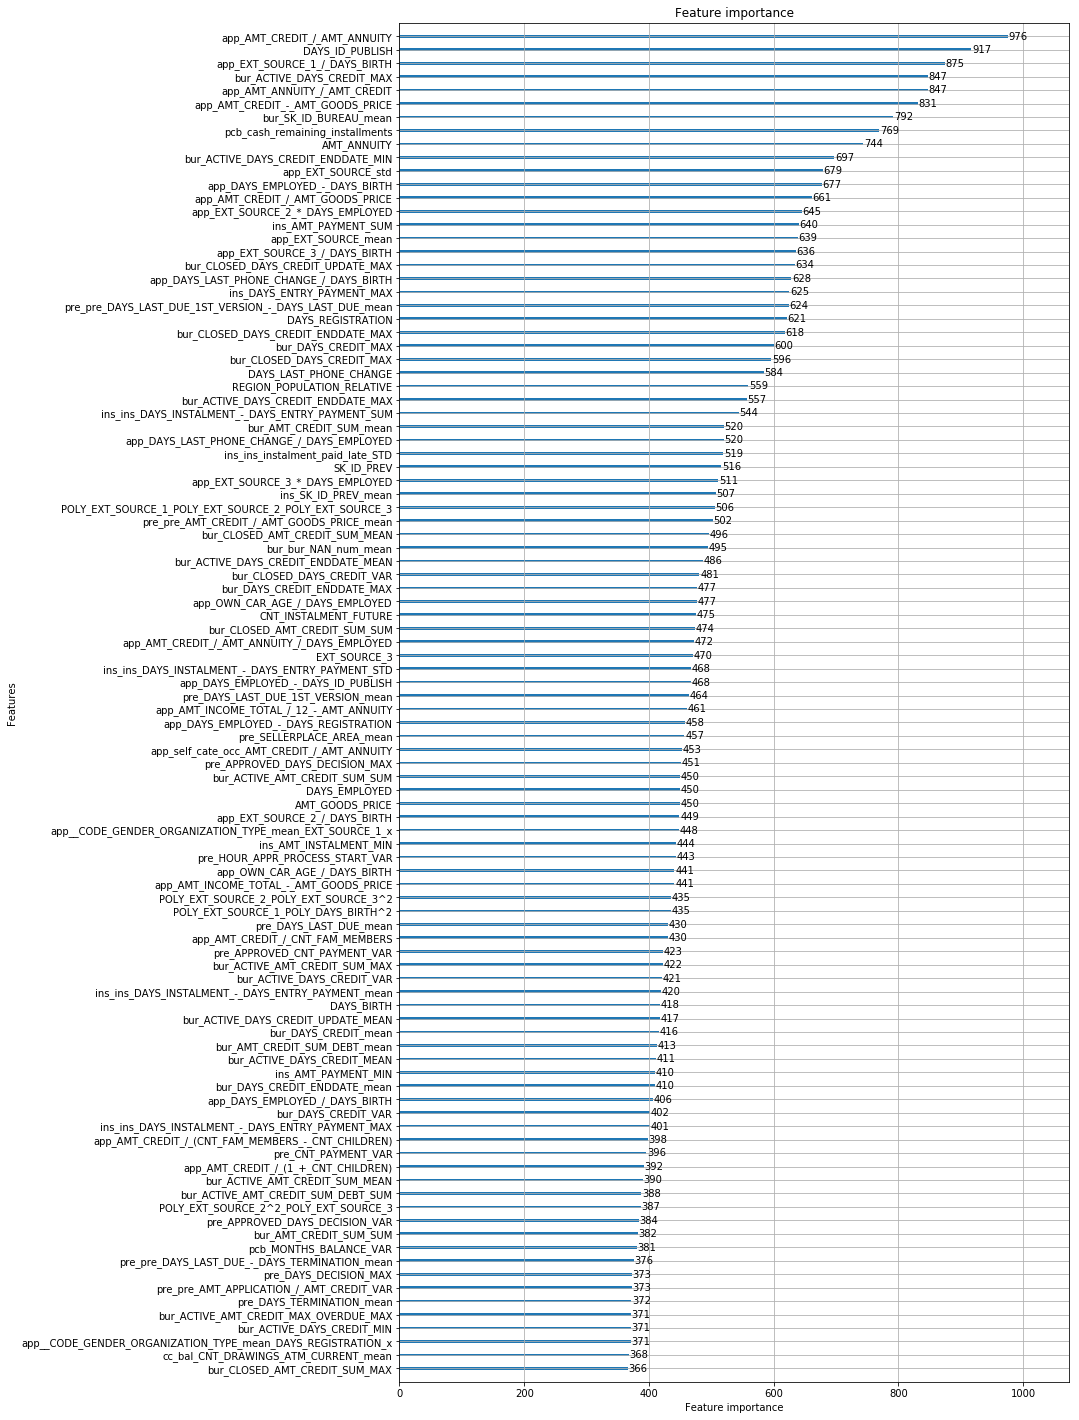

In [64]:
lgb.plot_importance(clf, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [65]:
preds = np.mean(list_preds, axis=0)

#preds = None

    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/17_all_5kfold.csv", index=False)
sub_lgb.head()

SK_ID_CURR    TARGET
0      100001  0.041796
1      100005  0.118849
2      100013  0.016569
3      100028  0.032895
4      100038  0.109894

In [66]:
print('17 plus features')
print(sc_auc_score, ',' ,max_score)

17 plus features
0.792744907562202 , 0.7949301263219315


In [67]:
print('result: ???')

result: ???


In [68]:
#16 plus features 3Kflold
#0.7911590072351249 , 0.7925018406854518
# 

In [69]:
#16 plus features 5K
#0.7929070667893783 , 0.7962524269814413


In [125]:
feature_importances_list = []

# 特徴量の表示
for i in range(0, clf.feature_importances_.size):
    index = clf.feature_importances_[i]
    feature_importances_list.append([trn_x.columns[i], clf.feature_importances_[i]])
    
    

In [124]:
trn_x.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'POLY_EXT_SOURCE_2^3', 'POLY_EXT_SOURCE_2^2 POLY_EXT_SOURCE_3',
       'POLY_EXT_SOURCE_2^2 POLY_DAYS_BIRTH',
       'POLY_EXT_SOURCE_2 POLY_EXT_SOURCE_3^2',
       'POLY_EXT_SOURCE_2 POLY_EXT_SOURCE_3 POLY_DAYS_BIRTH',
       'POLY_EXT_SOURCE_2 POLY_DAYS_BIRTH^2', 'POLY_EXT_SOURCE_3^3',
       'POLY_EXT_SOURCE_3^2 POLY_DAYS_BIRTH',
       'POLY_EXT_SOURCE_3 POLY_DAYS_BIRTH^2', 'POLY_DAYS_BIRTH^3'],
      dtype='object', length=1253)

In [126]:
pd_importancs = pd.DataFrame(feature_importances_list)
pd_importancs.columns = ['features', 'score']
pd_importancs.sort_values('score', ascending=False).to_csv('../output/feature_importances_17_5kfold.csv', index=False)
pd_importancs.sort_values('score', ascending=False)

features  score
111                        app AMT_CREDIT / AMT_ANNUITY    976
18                                      DAYS_ID_PUBLISH    917
135                       app EXT_SOURCE_1 / DAYS_BIRTH    875
672                          bur_ACTIVE_DAYS_CREDIT_MAX    847
120                        app AMT_ANNUITY / AMT_CREDIT    847
114                    app AMT_CREDIT - AMT_GOODS_PRICE    831
611                               bur SK_ID_BUREAU_mean    792
970                     pcb cash_remaining_installments    769
7                                           AMT_ANNUITY    744
675                  bur_ACTIVE_DAYS_CREDIT_ENDDATE_MIN    697
130                                  app EXT_SOURCE std    679
142                      app DAYS_EMPLOYED - DAYS_BIRTH    677
115                    app AMT_CREDIT / AMT_GOODS_PRICE    661
133                    app EXT_SOURCE_2 * DAYS_EMPLOYED    645
801                                 ins AMT_PAYMENT_SUM    640
129                                 app EXT_SOURCE mean    639
137                       app EXT_SOURCE_3 / DAYS_BIRTH    636
724                   bur_CLOSED_DAYS_CREDIT_UPDATE_MAX    634
140             app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH    628
804                          ins DAYS_ENTRY_PAYMENT_MAX    625
311   pre pre DAYS_LAST_DUE_1ST_VERSION - DAYS_LAST_...    624
17                                    DAYS_REGISTRATION    621
721                  bur_CLOSED_DAYS_CREDIT_ENDDATE_MAX    618
627                                 bur_DAYS_CREDIT_MAX    600
717                          bur_CLOSED_DAYS_CREDIT_MAX    596
93                               DAYS_LAST_PHONE_CHANGE    584
14                           REGION_POPULATION_RELATIVE    559
676                  bur_ACTIVE_DAYS_CREDIT_ENDDATE_MAX    557
782    ins ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT_SUM    544
618                             bur AMT_CREDIT_SUM_mean    520
...                                                 ...    ...
267   app _NAME_CONTRACT_TYPE_mean_app AMT_CREDIT / ...      0
950              last_100_ins instalment_paid_over_mean      0
949             last_100_ins instalment_paid_over_count      0
948    last_100_ins AMT_INSTALMENT - AMT_PAYMENT_median      0
947       last_100_ins AMT_INSTALMENT - AMT_PAYMENT_std      0
946       last_100_ins AMT_INSTALMENT - AMT_PAYMENT_min      0
945       last_100_ins AMT_INSTALMENT - AMT_PAYMENT_max      0
944      last_100_ins AMT_INSTALMENT - AMT_PAYMENT_mean      0
943       last_100_ins AMT_INSTALMENT - AMT_PAYMENT_sum      0
942              last_100_ins instalment_paid_late_mean      0
966                         NAME_CONTRACT_STATUS_Demand      0
969                            NAME_CONTRACT_STATUS_XNA      0
1027                         last_-30_SK_DPD_DEF_median      0
979                                  last_-1_SK_DPD_min      0
1026                            last_-30_SK_DPD_DEF_min      0
324   pre pre _NAME_PAYMENT_TYPE_mean_pre AMT_ANNUIT...      0
323   pre pre _NAME_PAYMENT_TYPE_mean_pre AMT_GOODS_...      0
322   pre pre _NAME_PAYMENT_TYPE_mean_pre AMT_CREDIT...      0
320   pre pre _NAME_CASH_LOAN_PURPOSE_mean_pre AMT_A...      0
157                     app self cate NAME_HOUSING_TYPE      0
1013                         last_-10_SK_DPD_DEF_median      0
1012                            last_-10_SK_DPD_DEF_min      0
702                   bur_ACTIVE_CNT_CREDIT_PROLONG_MAX      0
703                   bur_ACTIVE_CNT_CREDIT_PROLONG_MIN      0
999                           last_-6_SK_DPD_DEF_median      0
998                              last_-6_SK_DPD_DEF_min      0
993                                  last_-6_SK_DPD_min      0
985                           last_-1_SK_DPD_DEF_median      0
984                              last_-1_SK_DPD_DEF_min      0
888                  last_20_NUM_INSTALMENT_VERSION_min      0

[1253 rows x 2 columns]